# <center> Prácticas Externas 1 (Hospitales y Salud) </center> 
## <center> Análisis de los Parámetros del Hemograma utilizando Random Forest en Pacientes Infectados con SARS-CoV-2  </center> 
#### <center> *Jorge Alarcón Lucas y María González García* </center> 

El objetivo de estudio se centra en estudiar qué variables obtenidas por medio de hemogramas y qué variables relacionadas con la coagulación son especialmente importantes para el diagnóstico preventivo de infección SARS-CoV2.

Índice
1. Visualización de datos 
2. Identificación de valores perdidos 
3. Identificación de outliers
4. Tratamiento de variables categóricas
5. Separación en Train y Test
6. Tratamiento de valores perdidos
7. Tratamiento de variables AP y DD
8. Eliminación de variables redundantes
9. Árbol con todas las características
10. Búsqueda de hiperparámetros con Random Forest
11. Random Forest con todas las características
12. Selección de características (FS)
13. Random Forest con FS
14. Evaluación en test
15. Partials plots


In [ ]:
import pandas as pd
import numpy as np
import statistics as stats
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import scipy.stats as ss
import statistics as stats
import seaborn as sns 
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn.model_selection import  GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,recall_score, precision_score, confusion_matrix
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score

# 1. Visualización de datos 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Antes de entrenar un modelo predictivo, o antes de realizar cualquier cálculo con un nuevo conjunto de datos, es muy importante realizar un análisis descriptivo de los mismos. De esta forma, entender mejor la información que contiene cada variable y detectar posibles errores.

In [ ]:
db = pd.read_csv('Base datos Dimero D Septiembre.xlsx - Base datos.csv')
#db = pd.read_csv('/content/drive/MyDrive/[Practicas_Clinicas]/[PC-GIB] Hemograma_coagulacion_COVID_19/Base datos Dimero D Septiembre.xlsx - Base datos.csv')
db.head(7)

,Fecha Análisis,Número,Sexo del Paciente,Edad del Paciente,19nCv,LEU,NEU,NEUp,LIN,LINp,MON,MONp,EOS,EOSp,BAS,BASp,IG,IGp,ERIT,HGB,HCT,VCM,HCM,CHCM,RDW,ERBL,ERBLp,RET,RETp,FRI,RETHE,PLT,PLTI,PLTF,PLTO,VPM,IPF,rNe/L,rPL/L,MacR,...,HFLCP,LIN_a,LIN_p,LY-WX,LY-WY,LY-WZ,LY-X,LY-Y,LY-Z,MO-WX,MO-WY,MO-WZ,MO-X,MO-Y,MO-Z,NESFL,NESSC,NEU_a,NEU_p,NE-WX,NE-WY,NE-WZ,TNC-N,WBC-D,WBC-N,ASLYP,ASLYA,RELPL,RELYP,RELYA,NEUGI,NEURI,ASLPL,TPRO,AP,INR,TTPA,RTTP,FIB,DD
0,6/09/20,545613,F,68 años,Negativo,18.46,16.17,87.6,0.81,4.4,1.35,7.3,0.01,0.1,0.02,0.1,0.10,0.5,3.65,10.3,30.4,83.3,28.2,33.9,15.4,0.0,0.0,NaN,NaN,NaN,NaN,333,333,NaN,NaN,8.9,NaN,19.96,411.11,3.0,...,0.1,0.80,4.3,440,855,587,81.7,72.5,57.9,249,847,637,120.6,112.2,65.9,48.5,152.6,16.17,87.6,328,721,722,18.46,18.25,18.46,0,0,7.4,0.3,0.06,152.6,48.5,0,13.4,75,1.22,31.9,1.03,752,4395
1,10/09/20,552250,F,64 años,Negativo,10.36,8.18,78.9,0.91,8.8,0.84,8.1,0.32,3.1,0.06,0.6,0.05,0.5,4.17,11.9,36.8,88.2,28.5,32.3,12.6,0.0,0.0,NaN,NaN,NaN,NaN,396,396,NaN,NaN,10.8,NaN,8.99,435.16,3.2,...,0.0,0.91,8.8,493,1155,608,83.2,69.3,59.2,284,728,707,123.2,118.1,67.9,47.6,155.4,8.18,78.9,309,609,754,10.36,9.78,10.36,0,0,16.5,1.4,0.15,155.4,47.6,0,13.3,76,1.21,35.0,1.13,1172,1427
2,25/09/20,576545,F,44 años,Negativo,4.76,1.97,41.4,2.10,44.1,0.32,6.7,0.35,7.4,0.01,0.2,0.01,0.2,4.26,12.0,37.0,86.9,28.2,32.4,13.7,0.0,0.0,NaN,NaN,NaN,NaN,268,268,NaN,NaN,10,NaN,0.94,127.62,3.4,...,0.2,2.09,43.9,523,874,575,80.4,72.0,59.1,273,591,629,120.9,116.8,70.0,43.4,148.5,1.97,41.4,317,598,724,4.76,4.67,4.76,0,0,6.7,2.9,0.14,148.5,43.4,0,11.5,93,1.04,31.6,1.02,500,273
3,1/09/20,540952,F,48 años,Positivo,9.69,7.74,79.9,0.69,7.1,1.14,11.8,0.07,0.7,0.02,0.2,0.03,0.3,4.17,13.0,38.4,92.1,31.2,33.9,13.1,0.0,0.0,NaN,NaN,NaN,NaN,224,224,NaN,NaN,11.2,NaN,11.22,324.64,3.4,...,0.1,0.68,7.0,546,830,646,78.8,68.7,58.8,237,783,651,122.5,111.2,67.6,49.1,155.9,7.74,79.9,295,570,679,9.69,9.25,9.69,0,0,7.2,0.5,0.05,155.9,49.1,0,11.3,96,1.03,32.3,1.04,377,1461
4,29/09/20,582276,M,42 años,Positivo,5.83,3.92,67.2,1.35,23.2,0.52,8.9,0.00,0.0,0.01,0.2,0.03,0.5,5.09,14.3,43.0,84.5,28.1,33.3,12.9,0.0,0.0,NaN,NaN,NaN,NaN,192,192,NaN,NaN,10.8,NaN,2.90,142.22,4.1,...,0.7,1.31,22.5,461,815,663,82.4,72.3,58.8,264,680,690,121.3,117.6,65.3,46.8,152.0,3.92,67.2,322,577,729,5.83,5.75,5.83,0,0,8.9,2.1,0.12,152.0,46.8,0,13.0,78,1.18,34.9,1.13,744,651
5,1/09/20,540940,M,73 años,Negativo,0.34,0.07,20.6,0.25,73.5,0.02,5.9,0.00,0.0,0.00,0.0,0.00,0.0,2.41,7.6,21.2,88.0,31.5,35.8,13.5,0.0,0.0,NaN,NaN,NaN,NaN,10,10,NaN,NaN,----,NaN,0.28,40.00,2.6,...,0.0,0.25,73.5,308,685,560,84.3,73.0,60.7,19,22,109,108.0,90.0,55.0,68.0,135.0,0.07,20.6,274,603,264,0.34,0.34,0.34,----,----,----,----,----,135.0,68.0,----,14.8,65,1.34,30.3,0.98,826,837
6,14/09/20,556416,F,86 años,Negativo,6.96,3.38,48.6,2.76,39.7,0.71,10.2,0.07,1.0,0.03,0.4,0.01,0.1,4.76,14.3,44.1,92.6,30.0,32.4,14.6,0.0,0.0,NaN,NaN,NaN,NaN,196,196,NaN,NaN,11.3,NaN,1.22,71.01,4.3,...,0.0,2.76,39.7,436,744,580,82.5,73.9,60.3,288,748,658,121.3,117.7,68.4,46.2,146.7,3.38,48.6,314,584,667,6.96,6.70,6.96,0,0,4.7,1.9,0.13,146.7,46.2,0,10.1,>100,0.92,29.6,0.95,302,526


In [ ]:
Covid = db.groupby(['19nCv']).count()
print (Covid) 

          Fecha Análisis  Número  Sexo del Paciente  ...  RTTP  FIB   DD
19nCv                                                ...                
Negativo             522     522                522  ...   522  522  522
Positivo             310     310                310  ...   310  310  310

[2 rows x 91 columns]


In [ ]:
Sexo = db.groupby(['Sexo del Paciente']).count()
print (Sexo) 

                   Fecha Análisis  Número  Edad del Paciente  ...  RTTP  FIB   DD
Sexo del Paciente                                             ...                
F                             447     447                447  ...   447  447  447
M                             386     386                386  ...   386  386  386

[2 rows x 91 columns]


En una primera instancia, se observa como la base de datos presenta para ciertas variables valores perdidos. 

Las dos primeras columnas se consideran innnecesarias para la tarea predictiva, por lo que son eliminadas. 

In [ ]:
db=db.drop(["Número","Fecha Análisis"],axis=1)

## Tipo de cada columna

In [ ]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 90 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sexo del Paciente  833 non-null    object 
 1   Edad del Paciente  833 non-null    object 
 2   19nCv              832 non-null    object 
 3   LEU                833 non-null    float64
 4   NEU                833 non-null    float64
 5   NEUp               833 non-null    float64
 6   LIN                833 non-null    float64
 7   LINp               833 non-null    float64
 8   MON                833 non-null    float64
 9   MONp               833 non-null    float64
 10  EOS                833 non-null    float64
 11  EOSp               833 non-null    float64
 12  BAS                833 non-null    float64
 13  BASp               833 non-null    float64
 14  IG                 833 non-null    float64
 15  IGp                833 non-null    float64
 16  ERIT               833 non

Se observa como la variable *Edad* se encuentra como *object* debido a que la edad de cada paciente ha sido registrada seguida de la palabra "años". Por ello, se crea una función que permita eliminar dicha palabra y a su vez convertir la variable a tipo numérico. 

También, se precisa de otras variables como *object* cuando deberian de ser numéricas debido a la presencia de "----" que hacen referencia a valores perdidos. Por tanto, aquellas variables que presenten este conjunto de caracteres serán reemplazados por NaN. 

In [ ]:
# Función que elimina la palabra años
def only_digits (txt):
  return "".join(c for c in txt if c.isdigit())

db["Edad del Paciente"] = db["Edad del Paciente"].map(only_digits) 

# Reemplazo del conjunto de caracteres por NaN
db=db.replace("----",np.nan)


#Conversión de variables excepto Sexo del Pciente, 19nCv, DD y AP
for i in db:
  if not (i=="Sexo del Paciente" or i=="19nCv" or i=="DD" or i=="AP"):
    if db[i].dtypes == object:
      db[i] = pd.to_numeric(db[i])

In [ ]:
minimos =  db.loc[db["Edad del Paciente"].idxmin()]
maximos =  db.loc[db["Edad del Paciente"].idxmax()]
print (maximos,minimos)

Sexo del Paciente           F
Edad del Paciente         101
19nCv                Negativo
LEU                      7.12
NEU                      2.93
                       ...   
INR                      2.99
TTPA                     35.6
RTTP                     1.15
FIB                       527
DD                        903
Name: 421, Length: 90, dtype: object Sexo del Paciente           F
Edad del Paciente          16
19nCv                Negativo
LEU                      19.3
NEU                     15.13
                       ...   
INR                      1.17
TTPA                     33.6
RTTP                     1.08
FIB                       569
DD                        331
Name: 530, Length: 90, dtype: object


In [ ]:
minimos =  db.loc[db["Edad del Paciente"].mean()]

KeyError: ignored

# 2. Identificación valores perdidos

Junto con el estudio del tipo de variables, es básico conocer el número de observaciones disponibles y si todas ellas están completas. Los valores perdidos son muy importantes a la hora de crear modelos, la mayoría de algoritmos no aceptan observaciones incompletas o bien se ven muy influenciados por ellas.

In [ ]:
db.shape

(833, 90)

In [ ]:
# Columnas con missing values

for index,value in enumerate (db.isnull().sum()):
  if value !=0:
    print(db.columns[index],value)

19nCv 1
RET 830
RETp 830
FRI 830
RETHE 830
PLTF 833
PLTO 830
VPM 14
IPF 833
rNe/L 14
rPL/L 14
ASLYP 5
ASLYA 5
RELPL 5
RELYP 5
RELYA 5
ASLPL 5


In [ ]:
#Quitar todas las columnas con mas de 20 NaN

db=db.dropna(thresh=20,axis=1) 

In [ ]:
db.shape

(833, 83)

Se han eliminado 7 variables debido a la presencia de más de 20 valores perdidos por columna

Observando las columnas que presentan valores perdidos, una de ellas es la variable a predecir, 19nCv, lo cual no interesa dicho registro. Por ello, se elimina. 

In [ ]:
# Quitar la observación de la que no se sabe si es Positivo o no en COVID

for index,value in enumerate (db["19nCv"]):
  if value != "Positivo" and  value != "Negativo":
    db=db.drop(index)

In [ ]:
# Eliminando las columnas con escasos datos y la observación 

for index,value in enumerate (db.isnull().sum()):
  if value !=0:
    print(db.columns[index],value)

VPM 14
rNe/L 14
rPL/L 14
ASLYP 5
ASLYA 5
RELPL 5
RELYP 5
RELYA 5
ASLPL 5


# 3. Identificación outliers

Para detectar los outliers el primer paso es realizar una inspección visual a través de los boxplots y localizar aquellos que sobresalen del rango normal de valores.

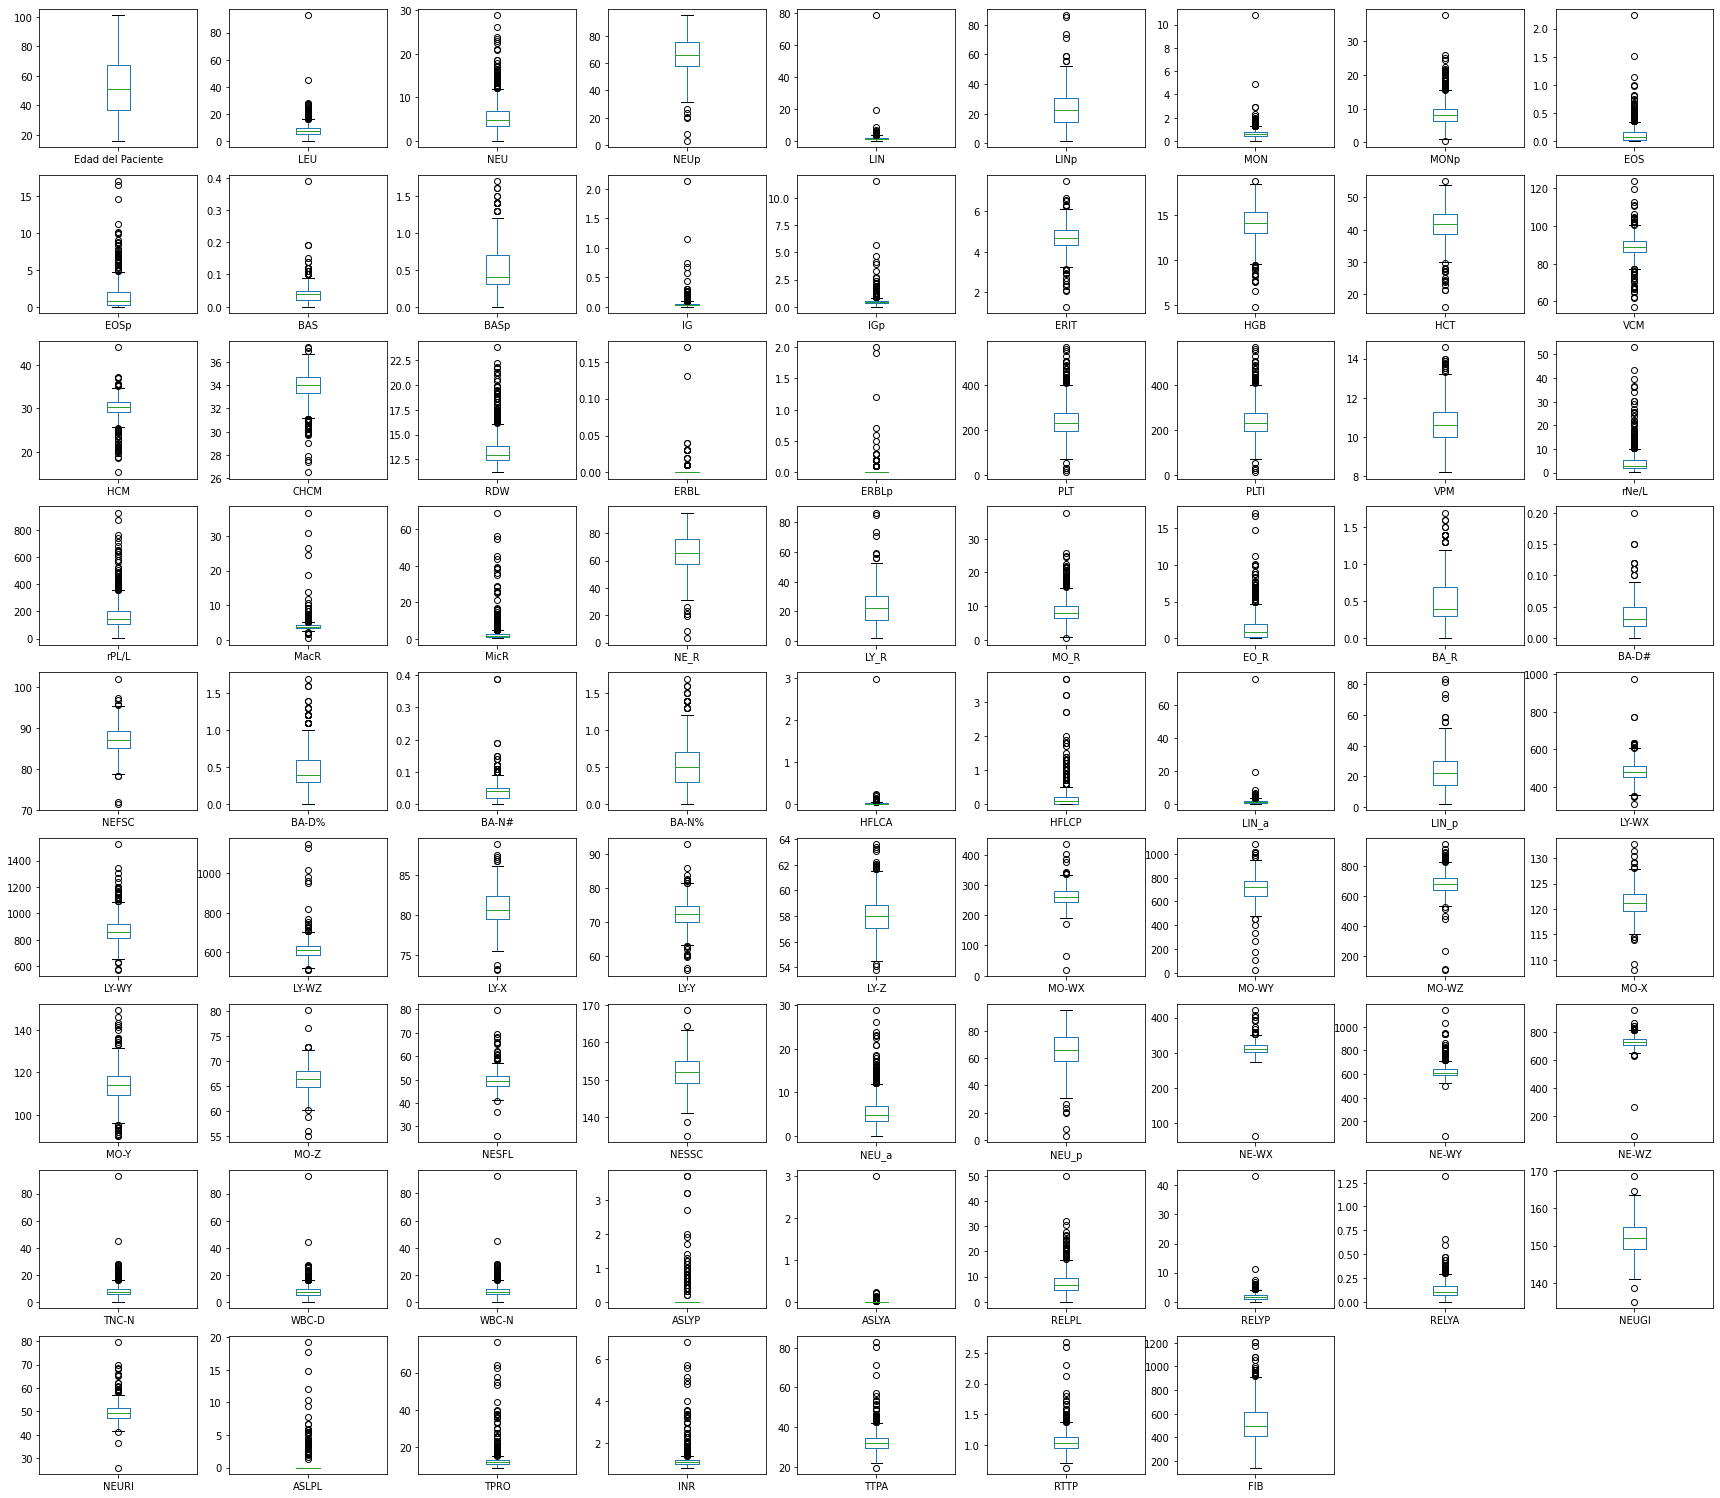

In [ ]:
db.plot(kind='box',subplots=True, layout=(10,9), sharex=False, sharey=False, figsize=(30,30));

El segundo paso, es calcular el z-score sin normalizar y comprobar si cada valor se encuentra dentro de 3.5 veces la desviación típica. En el caso de que se encuentren fuera de ese intervalo se le considera outlier y será reemplazado a NaN.

In [ ]:
def outliers (datos,dtype): #Función z-score
    count=0
    lista=[]
    for i in dtype[datos]:
        if not (dtype[datos].mean()-3*dtype[datos].std())<=i<=(dtype[datos].mean()+3*dtype[datos].std()): #sólo una prueba con 3 desviaciones en vez de 3.5 De hecho, se puede probar que en toda distirbución normal el 99.7 está
        #en tres desviaciones estándar. Aquí, lo mejor hubiese sido hacer un estudio de los histogramas y aplicar las transformaciones correspondientes (logarítmicas quizá). 
            if not np.isnan(i):
                count=count+1
                lista.append(i)
   
    return lista


numeric_variables = db.select_dtypes(exclude=['object'])

for i in numeric_variables:
    db[[i]]=db[[i]].replace(outliers(i,db),np.nan)                


In [ ]:
#Listado de variables con el número de valores NaN (outliers y missing values)

for index,value in enumerate (db.isnull().sum()):
  if value !=0:
    print(db.columns[index],value)

LEU 9
NEU 14
NEUp 5
LIN 2
LINp 6
MON 5
MONp 13
EOS 16
EOSp 17
BAS 6
BASp 12
IG 6
IGp 9
ERIT 10
HGB 10
HCT 9
VCM 18
HCM 17
CHCM 9
RDW 21
ERBL 9
ERBLp 7
PLT 11
PLTI 11
VPM 22
rNe/L 33
rPL/L 30
MacR 8
MicR 16
NE_R 5
LY_R 6
MO_R 13
EO_R 17
BA_R 12
BA-D# 9
NEFSC 5
BA-D% 9
BA-N# 8
BA-N% 13
HFLCA 1
HFLCP 15
LIN_a 2
LIN_p 6
LY-WX 4
LY-WY 10
LY-WZ 7
LY-X 5
LY-Y 8
LY-Z 5
MO-WX 7
MO-WY 6
MO-WZ 7
MO-X 5
MO-Y 9
MO-Z 5
NESFL 12
NESSC 3
NEU_a 14
NEU_p 5
NE-WX 7
NE-WY 15
NE-WZ 4
TNC-N 9
WBC-D 9
WBC-N 9
ASLYP 19
ASLYA 6
RELPL 18
RELYP 8
RELYA 14
NEUGI 3
NEURI 12
ASLPL 23
TPRO 18
INR 18
TTPA 10
RTTP 10
FIB 7


Boxplots tras la sustitución de los outliers a valores NaN

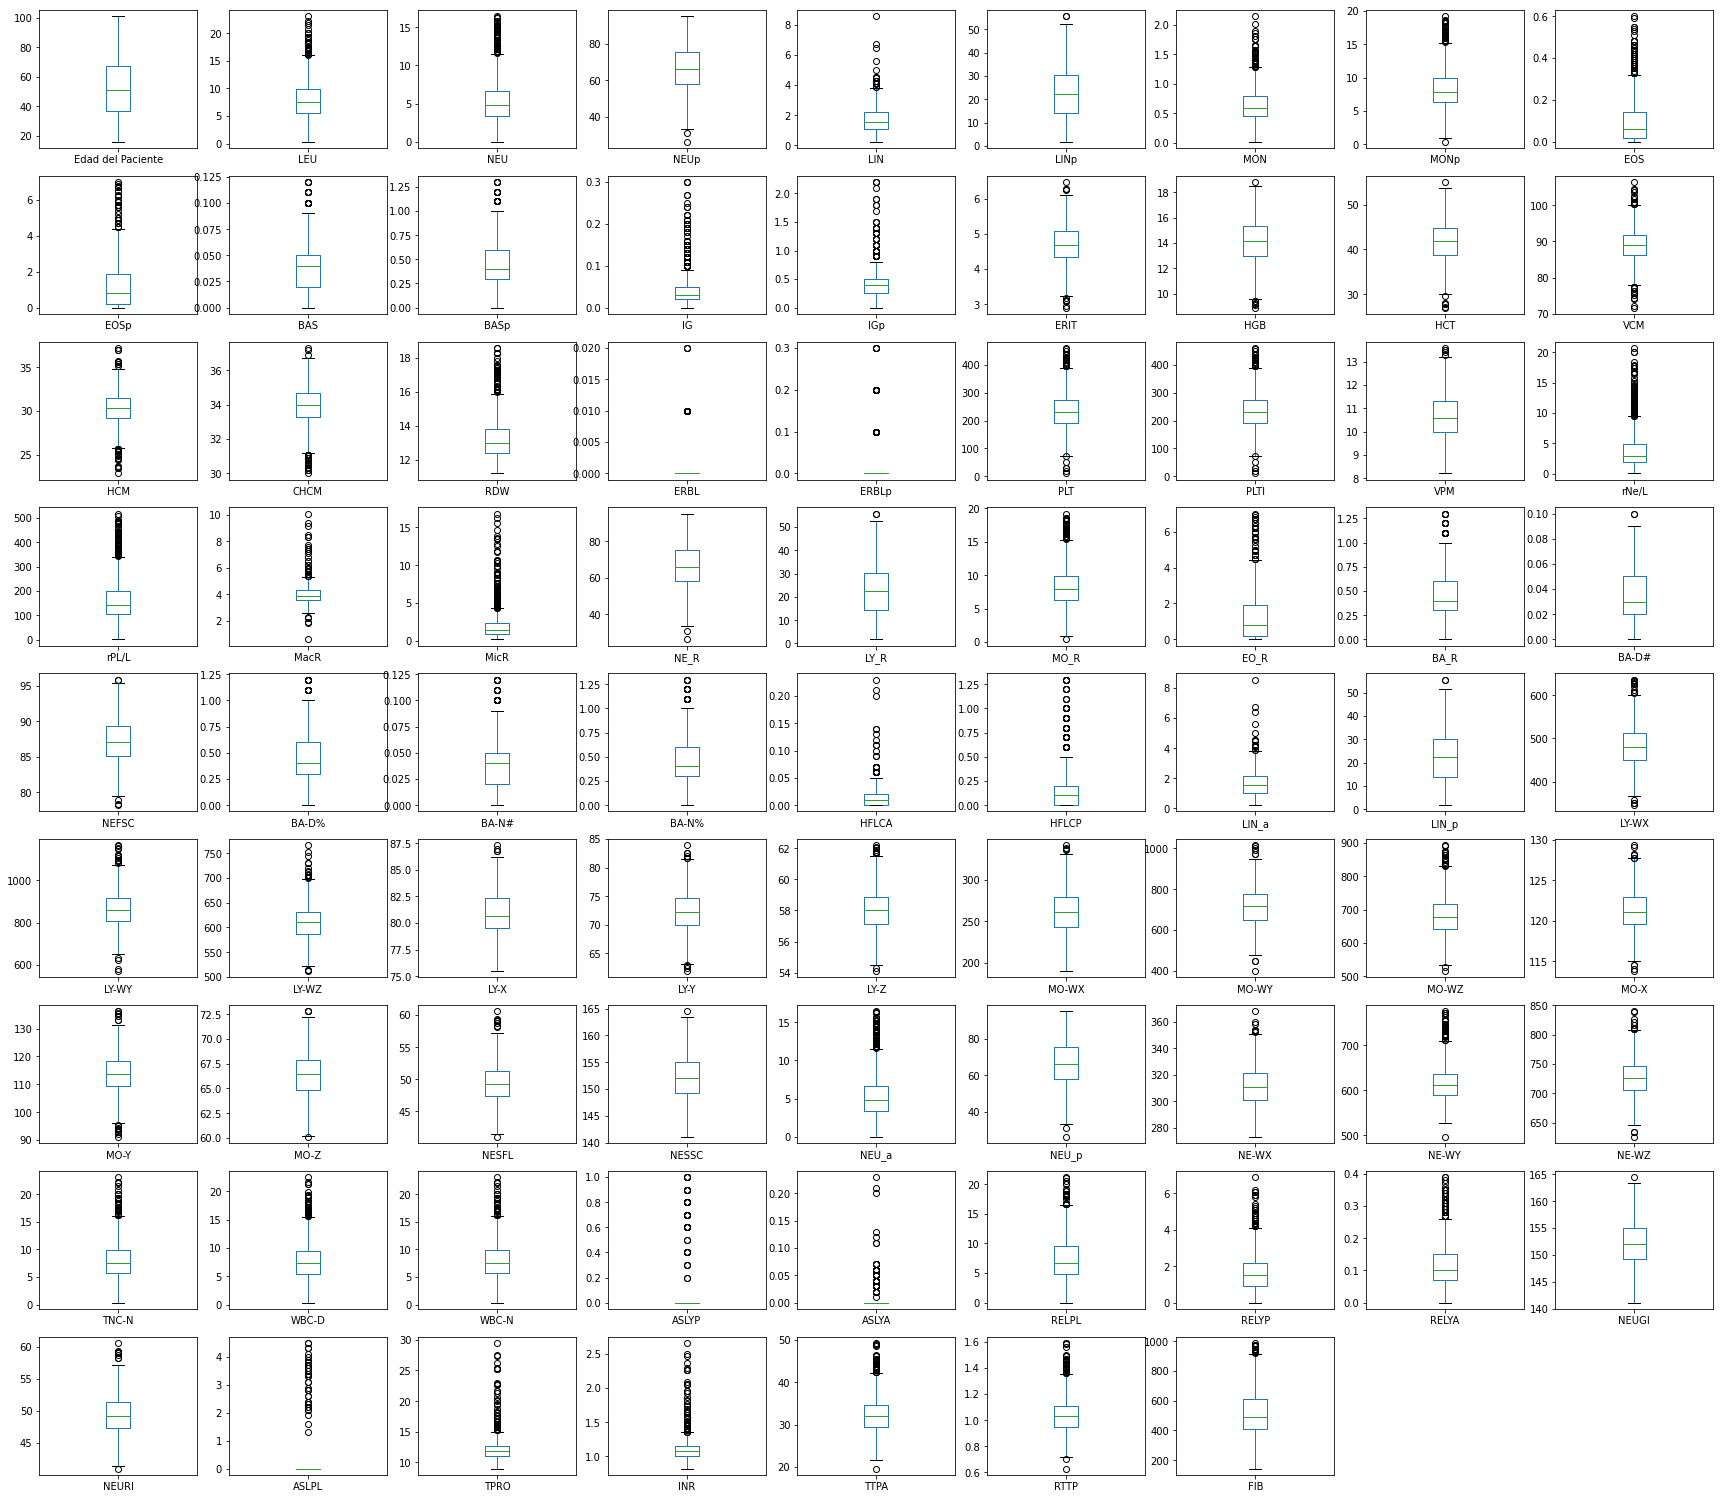

In [ ]:
db.plot(kind='box',subplots=True, layout=(10,9), sharex=False, sharey=False, figsize=(30,30));

# 4. Tratamiento de variables categóricas 

In [ ]:
# Se convierte la variable Sexo del paciente y 19nCv a variable categórica

db['Sexo del Paciente'] = db['Sexo del Paciente'].astype('category').cat.codes # 0 --> Femenino, 1--> Masculino
db['19nCv'] = db['19nCv'].astype('category').cat.codes # 0 --> Negativo, 1--> Positivo

In [ ]:
# Tipo de cada columna 

db['Sexo del Paciente']= db['Sexo del Paciente'].astype('category')
db['19nCv'] = db['19nCv'].astype('category')
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 832 entries, 0 to 832
Data columns (total 83 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Sexo del Paciente  832 non-null    category
 1   Edad del Paciente  832 non-null    int64   
 2   19nCv              832 non-null    category
 3   LEU                823 non-null    float64 
 4   NEU                818 non-null    float64 
 5   NEUp               827 non-null    float64 
 6   LIN                830 non-null    float64 
 7   LINp               826 non-null    float64 
 8   MON                827 non-null    float64 
 9   MONp               819 non-null    float64 
 10  EOS                816 non-null    float64 
 11  EOSp               815 non-null    float64 
 12  BAS                826 non-null    float64 
 13  BASp               820 non-null    float64 
 14  IG                 826 non-null    float64 
 15  IGp                823 non-null    float64 
 16  ERIT    

Todas las variables presentan el tipo correcto. 

# 5. Separación en Train y Test

Para poder crear de forma correcta el modelo, se necesita disponer de un conjunto de observaciones, de las que se conozca la variable de salida. Con esta finalidad, se dividen los datos disponibles en un conjunto de entrenamiento y un conjunto de test, siendo 80%-20% respectivamente. La partición se va a realizar de forma aleatoria y estratificada, para que la proporción de observaciones de cada clase en el conjunto de test y en el conjunto de diseño es la misma. 

In [ ]:
X_all = db.copy().drop("19nCv",axis=1)
Y_all = db["19nCv"]

X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, test_size = 0.2, random_state = 2, stratify = db["19nCv"])

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(X_train.columns)

(665, 82)
(167, 82)
(665,)
(167,)
Index(['Sexo del Paciente', 'Edad del Paciente', 'LEU', 'NEU', 'NEUp', 'LIN',
       'LINp', 'MON', 'MONp', 'EOS', 'EOSp', 'BAS', 'BASp', 'IG', 'IGp',
       'ERIT', 'HGB', 'HCT', 'VCM', 'HCM', 'CHCM', 'RDW', 'ERBL', 'ERBLp',
       'PLT', 'PLTI', 'VPM', 'rNe/L', 'rPL/L', 'MacR', 'MicR', 'NE_R', 'LY_R',
       'MO_R', 'EO_R', 'BA_R', 'BA-D#', 'NEFSC', 'BA-D%', 'BA-N#', 'BA-N%',
       'HFLCA', 'HFLCP', 'LIN_a', 'LIN_p', 'LY-WX', 'LY-WY', 'LY-WZ', 'LY-X',
       'LY-Y', 'LY-Z', 'MO-WX', 'MO-WY', 'MO-WZ', 'MO-X', 'MO-Y', 'MO-Z',
       'NESFL', 'NESSC', 'NEU_a', 'NEU_p', 'NE-WX', 'NE-WY', 'NE-WZ', 'TNC-N',
       'WBC-D', 'WBC-N', 'ASLYP', 'ASLYA', 'RELPL', 'RELYP', 'RELYA', 'NEUGI',
       'NEURI', 'ASLPL', 'TPRO', 'AP', 'INR', 'TTPA', 'RTTP', 'FIB', 'DD'],
      dtype='object')


# 6. Tratamiento de valores perdidos

Se reemplazan los valores NaN (valores perdidos y outliers) por el estadístico mediana. Para el conjunto de test se aplica la mediana del conjunto de entrenamiento ya que no tenemos un conocimiento a priori del conjunto de test.

**X_train**

In [ ]:
X_train = X_train.fillna(X_train.median()) 


#Comprobación de que se han reemplazado todos correctamente

X_train.isnull().sum()

Sexo del Paciente    0
Edad del Paciente    0
LEU                  0
NEU                  0
NEUp                 0
                    ..
INR                  0
TTPA                 0
RTTP                 0
FIB                  0
DD                   0
Length: 82, dtype: int64


No hay presencia de missing values en este conjunto de datos. Para asegurar este resultado, se realiza un análisis de cada variable del conjunto de X_train para ver si hay alguna incoherencia.

In [ ]:
X_train.describe()

,Edad del Paciente,LEU,NEU,NEUp,LIN,LINp,MON,MONp,EOS,EOSp,BAS,BASp,IG,IGp,ERIT,HGB,HCT,VCM,HCM,CHCM,RDW,ERBL,ERBLp,PLT,PLTI,VPM,rNe/L,rPL/L,MacR,MicR,NE_R,LY_R,MO_R,EO_R,BA_R,BA-D#,NEFSC,BA-D%,BA-N#,BA-N%,HFLCA,HFLCP,LIN_a,LIN_p,LY-WX,LY-WY,LY-WZ,LY-X,LY-Y,LY-Z,MO-WX,MO-WY,MO-WZ,MO-X,MO-Y,MO-Z,NESFL,NESSC,NEU_a,NEU_p,NE-WX,NE-WY,NE-WZ,TNC-N,WBC-D,WBC-N,ASLYP,ASLYA,RELPL,RELYP,RELYA,NEUGI,NEURI,ASLPL,TPRO,INR,TTPA,RTTP,FIB
count,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000
mean,52.715789,8.167827,5.468496,66.278797,1.701429,22.620752,0.665278,8.408120,0.096977,1.234586,0.038827,0.478195,0.039414,0.424662,4.689850,14.125865,41.593083,89.100451,30.328421,33.945414,13.286316,0.001353,0.018496,233.257143,233.237594,10.652481,4.022150,165.809774,4.003158,2.082857,66.278797,22.620752,8.408120,1.234586,0.478195,0.033895,87.201429,0.433835,0.039113,0.481053,0.014105,0.185564,1.687308,22.404286,481.753383,863.672180,611.530827,80.981053,72.588872,58.075639,261.351880,715.845865,682.812030,121.310677,113.966316,66.327218,49.398045,152.146391,5.468496,66.278797,311.401504,618.279699,727.234586,8.170278,7.950436,8.168263,0.031729,0.003594,7.604812,1.673684,0.119699,152.146391,49.398045,0.132782,12.300150,1.116541,32.196692,1.038827,519.371429
std,19.325185,3.577455,2.994750,12.572584,0.901670,10.830479,0.306729,3.154127,0.109072,1.346629,0.023500,0.253333,0.042637,0.298731,0.550265,1.711757,4.475295,4.856561,2.012219,1.191984,1.307995,0.003510,0.052390,68.994533,68.957561,0.921724,3.360631,88.346012,0.785892,2.271870,12.572584,10.830479,3.154127,1.346629,0.253333,0.019689,3.032043,0.242566,0.023637,0.253355,0.020801,0.247522,0.900655,10.748804,45.757736,89.959986,36.711871,2.075126,3.692188,1.362142,26.281426,98.135897,60.134056,2.537144,7.235239,2.272815,3.034046,4.272978,2.994750,12.572584,15.200160,43.773341,32.208737,3.577796,3.479797,3.577161,0.151003,0.017247,3.743843,1.101402,0.072587,4.272978,3.034046,0.655497,2.305314,0.206961,4.415067,0.142476,150.711512
min,16.000000,0.340000,0.070000,26.300000,0.230000,1.800000,0.020000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.900000,8.900000,27.000000,71.700000,22.900000,30.000000,11.200000,0.000000,0.000000,10.000000,10.000000,8.200000,0.030000,1.520000,0.600000,0.200000,26.300000,1.800000,0.400000,0.000000,0.000000,0.000000,78.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.210000,1.800000,346.000000,570.000000,512.000000,75.500000,62.500000,54.100000,190.000000,400.000000,516.000000,113.800000,92.700000,60.100000,41.000000,141.100000,0.070000,26.300000,273.000000,497.000000,626.000000,0.340000,0.340000,0.340000,0.000000,0.000000,0.000000,0.000000,0.000000,141.100000,41.000000,0.000000,9.300000,0.850000,19.600000,0.630000,144.000000
25%,37.000000,5.670000,3.440000,58.100000,1.080000,14.300000,0.480000,6.400000,0.020000,0.200000,0.020000,0.300000,0.020000,0.200000,4.350000,13.100000,38.800000,86.200000,29.200000,33.300000,12.400000,0.000000,0.000000,191.000000,191.000000,10.000000,1.930000,106.580000,3.600000,0.900000,58.100000,14.300000,6.400000,0.200000,0.300000,0.020000,85.000000,0.300000,0.020000,0.300000,0.000000,0.000000,1.050000,14.000000,451.0000

**X_test**

In [ ]:
X_test = X_test.fillna(X_train.median()) 


#Comprobación de que se han reemplazado todos correctamente

X_test.isnull().sum()


Sexo del Paciente    0
Edad del Paciente    0
LEU                  0
NEU                  0
NEUp                 0
                    ..
INR                  0
TTPA                 0
RTTP                 0
FIB                  0
DD                   0
Length: 82, dtype: int64

# 7. Tratamiento de variables AP y DD

Se observa como tanto la variable AP y DD presentan valores predecidos de "<" o ">".

En el caso de la variable DD como solo se presenta de una observación con dicho caracter, se procede a la sustitución de éste por el valor, eliminando el caracter "<".

In [ ]:
print(X_all['DD'][X_all['DD'] == '<215'])

#Solo hay un caso, lo sustituimos por 215

X_train['DD'][X_train['DD'] == '<215'] = 215
print(X_train['DD'][X_train['DD'] == '<215'] )

298    <215
Name: DD, dtype: object
Series([], Name: DD, dtype: object)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Sin embargo, para la variable AP, no es posible eliminar solamente el caracter, ya que en la base de datos se observan bastantes registros con un valor 100 y mayores que 100. 

Para solventar este problema, se van a estimar dichos valores < 100 por medio de una distribución exponencial. 

Los pasos a seguir son:

1.- Representar el histogramas de la variable AP 

2.- Encontrar una función de densidad de probabilidad (pdf) analítica que se ajuste al conjunto de datos de la variable AP  

3.- Realizar un muestreo de la pdf

4.- Generar 10000 muestras con esa pdf 

5.- Tomar solamente aquellos valores mayores de 100

6.- Asignar dichos valores a aquellos que presenten  > 100 

In [ ]:
AP_train_p = X_train['AP'][X_train['AP']=='>100']
print(AP_train_p.shape)

AP_test_p = X_test['AP'][X_test['AP']=='>100']
print(AP_test_p.shape)

(127,)
(29,)


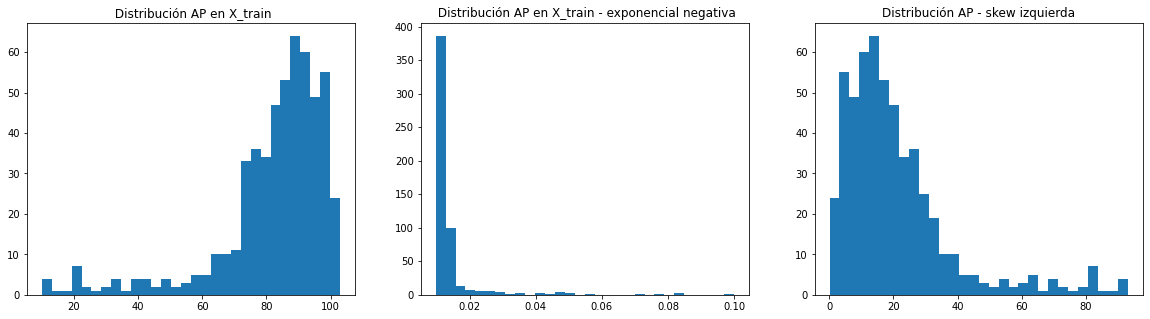

In [ ]:
AP_train = X_train['AP'][X_train['AP']!='>100'].to_numpy(dtype = float)

AP_test = X_test['AP'][X_test['AP']!='>100'].to_numpy(dtype = float)


plt.figure(figsize = (20,5))

plt.subplot(131)
plt.title(" Distribución AP en X_train")
plt.hist(AP_train,bins = 30);

plt.subplot(132)
plt.title(" Distribución AP en X_train - exponencial negativa")
plt.hist(1/AP_train,bins = 30);

#change skew
plt.subplot(133)     
plt.title("Distribución AP - skew izquierda" )
plt.hist((np.max(AP_train)+0.1-AP_train),bins = 30); 



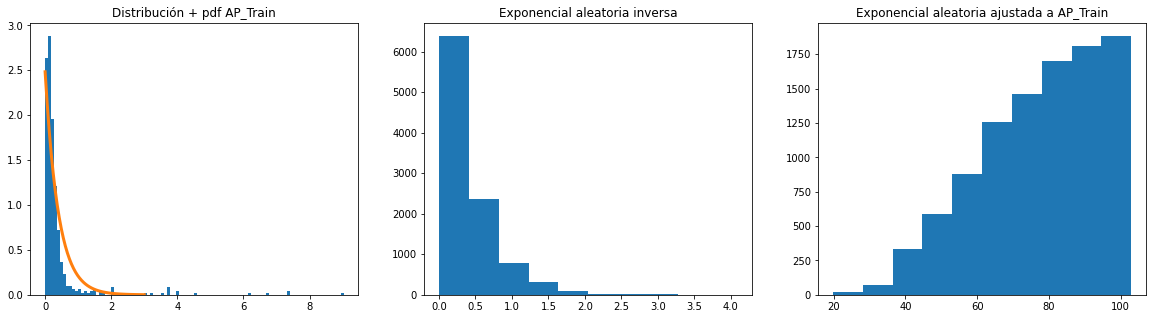

In [ ]:
#Se ajusta exponencial

#Se convierte datos 

x = 1/(AP_train)*100 
minimo = np.min(x)
x = x - np.min(x)  #desplaza el histograma para que empiece en cero 
theta_hat = len(x)/np.sum(x)  # Para ajustar la pdf


plt.figure(figsize=(20,5))

#Pdf de AP_Train y Distribución de AP exponencial negativa 
plt.subplot(131)
plt.title("Distribución + pdf AP_Train")
plt.hist(x,bins = 100,density = True)
xx = np.linspace(0,3)
pdf = theta_hat * np.exp(-theta_hat*xx)
plt.plot(xx,pdf,linewidth = 3)

#generamos datos y hacemos transformada inversa
cand = np.random.exponential(1/theta_hat,int(1e4)) 
plt.subplot(132)
plt.title("Exponencial aleatoria inversa")
plt.hist(cand)

# para que aparezcan valores de 100 y se le da la vuelta
cand_ap = 100 / (cand +minimo) 
plt.subplot(133)
plt.title("Exponencial aleatoria ajustada a AP_Train")
plt.hist(cand_ap);            



#nos quedamos con aquellos valores mayores de 100 
x_AP_big_100 = cand_ap[cand_ap > 100]


Previamente, se realiza una cambio de skew, ya que para ajustar nuestros datos a una distribución exponencial, ésta se encuentra como una exponencial negativa.

A partir de los datos de entrenamiento que no presentan dichos valores problemáticos se ajusta una función de densidad de probabilidad (pdf) exponencial como se observa en la primera gráfica. A pàrtir de ésta, se observa como los datos de AP_train se distribuyen aproximadamente a una pdf exponencial. 

Así pues, se extraen muestras de una distribución exponencial utilizando como parámetro, theta, calculado a partir de los datos de AP_train. 

Para finalizar, se le vuelve a dar la vuelta a la exponencial como se encontraba la distribución de los datos originales y se realiza de nuevo una transformación para que se puedan escoger aquellos valores mayores de 100. 


## AP-DD Train

In [ ]:
# Reemplace de los valores ">100" por valores de la nueva exponencial 

AP_train_100 = X_train['AP'][X_train['AP']=='>100']

a = np.random.choice(x_AP_big_100.astype(str),X_train['AP'].shape[0])

for i,v in enumerate (X_train['AP']):
  if v == ">100":
    X_train['AP'].iloc[i]=(X_train['AP'].iloc[i]).replace(v,list(a)[i])

#Transformación de los valores a tu tipo 

X_train['AP'] = X_train['AP'].to_numpy(dtype = float)
X_train['DD'] = X_train['DD'].to_numpy(dtype = float)



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
X_train.describe()

,Edad del Paciente,LEU,NEU,NEUp,LIN,LINp,MON,MONp,EOS,EOSp,BAS,BASp,IG,IGp,ERIT,HGB,HCT,VCM,HCM,CHCM,RDW,ERBL,ERBLp,PLT,PLTI,VPM,rNe/L,rPL/L,MacR,MicR,NE_R,LY_R,MO_R,EO_R,BA_R,BA-D#,NEFSC,BA-D%,BA-N#,BA-N%,...,HFLCP,LIN_a,LIN_p,LY-WX,LY-WY,LY-WZ,LY-X,LY-Y,LY-Z,MO-WX,MO-WY,MO-WZ,MO-X,MO-Y,MO-Z,NESFL,NESSC,NEU_a,NEU_p,NE-WX,NE-WY,NE-WZ,TNC-N,WBC-D,WBC-N,ASLYP,ASLYA,RELPL,RELYP,RELYA,NEUGI,NEURI,ASLPL,TPRO,AP,INR,TTPA,RTTP,FIB,DD
count,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,...,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000,665.000000
mean,52.715789,8.167827,5.468496,66.278797,1.701429,22.620752,0.665278,8.408120,0.096977,1.234586,0.038827,0.478195,0.039414,0.424662,4.689850,14.125865,41.593083,89.100451,30.328421,33.945414,13.286316,0.001353,0.018496,233.257143,233.237594,10.652481,4.022150,165.809774,4.003158,2.082857,66.278797,22.620752,8.408120,1.234586,0.478195,0.033895,87.201429,0.433835,0.039113,0.481053,...,0.185564,1.687308,22.404286,481.753383,863.672180,611.530827,80.981053,72.588872,58.075639,261.351880,715.845865,682.812030,121.310677,113.966316,66.327218,49.398045,152.146391,5.468496,66.278797,311.401504,618.279699,727.234586,8.170278,7.950436,8.168263,0.031729,0.003594,7.604812,1.673684,0.119699,152.146391,49.398045,0.132782,12.300150,85.798290,1.116541,32.196692,1.038827,519.371429,1129.899248
std,19.325185,3.577455,2.994750,12.572584,0.901670,10.830479,0.306729,3.154127,0.109072,1.346629,0.023500,0.253333,0.042637,0.298731,0.550265,1.711757,4.475295,4.856561,2.012219,1.191984,1.307995,0.003510,0.052390,68.994533,68.957561,0.921724,3.360631,88.346012,0.785892,2.271870,12.572584,10.830479,3.154127,1.346629,0.253333,0.019689,3.032043,0.242566,0.023637,0.253355,...,0.247522,0.900655,10.748804,45.757736,89.959986,36.711871,2.075126,3.692188,1.362142,26.281426,98.135897,60.134056,2.537144,7.235239,2.272815,3.034046,4.272978,2.994750,12.572584,15.200160,43.773341,32.208737,3.577796,3.479797,3.577161,0.151003,0.017247,3.743843,1.101402,0.072587,4.272978,3.034046,0.655497,2.305314,17.382066,0.206961,4.415067,0.142476,150.711512,3401.292266
min,16.000000,0.340000,0.070000,26.300000,0.230000,1.800000,0.020000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.900000,8.900000,27.000000,71.700000,22.900000,30.000000,11.200000,0.000000,0.000000,10.000000,10.000000,8.200000,0.030000,1.520000,0.600000,0.200000,26.300000,1.800000,0.400000,0.000000,0.000000,0.000000,78.200000,0.000000,0.000000,0.000000,...,0.000000,0.210000,1.800000,346.000000,570.000000,512.000000,75.500000,62.500000,54.100000,190.000000,400.000000,516.000000,113.800000,92.700000,60.100000,41.000000,141.100000,0.070000,26.300000,273.000000,497.000000,626.000000,0.340000,0.340000,0.340000,0.000000,0.000000,0.000000,0.000000,0.000000,141.100000,41.000000,0.000000,9.300000,10.000000,0.850000,19.600000,0.630000,144.000000,48.000000
25%,37.000000,5.670000,3.440000,58.100000,1.080000,14.300000,0.480000,6.400000,0.020000,0.200000,0.020000,0.300000,0.020000,0.200000,4.350000,13.100000,38.800000,86.200000,29.200000,33.300000,12.400000,0.000000,0.000000,191.000000,191.000000,10.000000,1.930000,106.580000,3.600000,0.900000,58.100000,14.300000,6.400000,0.200000,0.300000,0.020000,85.000000,0.30

## AP-DD Test 

Se realiza lo mismo para el conjunto de test, pero la sustitución se realiza por los obtenidos con el conjunto de entrenamiento. 

In [ ]:
# Reemplace de los valores ">100" por valores de la nueva exponencial 

a = np.random.choice(x_AP_big_100.astype(str),X_test['AP'].shape[0])
for i,v in enumerate (X_test['AP']):
  if v == ">100":
    X_test['AP'].iloc[i]=(X_test['AP'].iloc[i]).replace(v,list(a)[i])


#Transformación de los valores a tu tipo 

X_test['AP'] = X_test['AP'].to_numpy(dtype = float)
X_test['DD'] = X_test['DD'].to_numpy(dtype = float)


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
X_test.describe()

,Edad del Paciente,LEU,NEU,NEUp,LIN,LINp,MON,MONp,EOS,EOSp,BAS,BASp,IG,IGp,ERIT,HGB,HCT,VCM,HCM,CHCM,RDW,ERBL,ERBLp,PLT,PLTI,VPM,rNe/L,rPL/L,MacR,MicR,NE_R,LY_R,MO_R,EO_R,BA_R,BA-D#,NEFSC,BA-D%,BA-N#,BA-N%,...,HFLCP,LIN_a,LIN_p,LY-WX,LY-WY,LY-WZ,LY-X,LY-Y,LY-Z,MO-WX,MO-WY,MO-WZ,MO-X,MO-Y,MO-Z,NESFL,NESSC,NEU_a,NEU_p,NE-WX,NE-WY,NE-WZ,TNC-N,WBC-D,WBC-N,ASLYP,ASLYA,RELPL,RELYP,RELYA,NEUGI,NEURI,ASLPL,TPRO,AP,INR,TTPA,RTTP,FIB,DD
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,...,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.00000,167.000000,167.000000
mean,52.760479,8.077725,5.534671,66.089820,1.710000,23.338323,0.613593,8.053293,0.111617,1.321557,0.039401,0.483234,0.040719,0.435329,4.718443,14.128144,41.762874,88.683832,30.071257,33.839521,13.309581,0.001377,0.017964,239.712575,239.712575,10.702994,4.079042,168.276048,4.047904,2.129341,65.878443,23.338323,8.053293,1.321557,0.483234,0.035389,87.276048,0.454491,0.039521,0.483234,...,0.197006,1.695210,23.100898,487.658683,862.802395,608.736527,80.759281,71.509581,58.077844,261.970060,717.739521,686.497006,121.166467,113.264671,66.395808,49.445509,152.282036,5.534671,65.878443,311.275449,612.754491,727.017964,8.079102,7.864731,8.077725,0.042515,0.005150,6.794611,1.591617,0.111677,152.282036,49.445509,0.197605,12.072455,87.380218,1.095509,32.230539,1.04006,521.185629,1045.802395
std,20.423295,3.392781,3.089113,13.096425,0.861023,11.089356,0.277895,3.028017,0.120438,1.363912,0.024265,0.268115,0.039978,0.272887,0.563816,1.687976,4.553795,4.135001,1.767549,1.084888,1.287813,0.003627,0.049461,71.034957,71.034957,0.926805,3.480143,86.971452,0.710577,2.004552,12.976272,11.089356,3.028017,1.363912,0.268115,0.020645,2.684566,0.248539,0.024243,0.268115,...,0.250644,0.862592,11.051253,48.133070,89.733490,33.944356,1.962914,3.518852,1.357017,26.834483,95.215574,62.089507,2.504036,7.588681,2.301371,2.806011,3.943827,3.089113,12.976272,16.557918,38.644420,32.681278,3.393290,3.316704,3.392781,0.164795,0.022916,3.322564,1.016871,0.067891,3.943827,2.806011,0.775137,1.832592,14.993459,0.164576,3.993877,0.12830,139.064933,1852.251298
min,17.000000,0.370000,0.030000,33.300000,0.320000,3.700000,0.020000,0.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.320000,9.700000,29.500000,77.300000,25.600000,30.500000,11.400000,0.000000,0.000000,20.000000,20.000000,8.900000,0.090000,57.410000,2.700000,0.300000,33.300000,3.700000,0.900000,0.000000,0.000000,0.000000,78.900000,0.000000,0.000000,0.000000,...,0.000000,0.310000,3.700000,350.000000,630.000000,529.000000,76.500000,61.900000,54.300000,190.000000,450.000000,554.000000,114.500000,91.100000,60.700000,41.800000,141.800000,0.030000,33.300000,276.000000,540.000000,635.000000,0.370000,0.330000,0.370000,0.000000,0.000000,0.500000,0.100000,0.010000,141.800000,41.800000,0.000000,9.000000,14.000000,0.820000,22.300000,0.72000,269.000000,77.000000
25%,37.000000,5.330000,3.185000,56.800000,1.065000,14.050000,0.415000,6.250000,0.020000,0.300000,0.020000,0.300000,0.020000,0.300000,4.320000,13.000000,38.800000,86.550000,29.100000,33.300000,12.350000,0.000000,0.000000,199.500000,199.500000,10.000000,1.775000,106.035000,3.600000,0.900000,56.650000,14.050000,6.250000,0.300000,0.300000,0.020000,85.500000,0.30000

# 8. Eliminar variables redundantes utilizando hierarchical clustering

Para eliminar variables redundantes, es decir, aquellas que ofrecen la misma información, se hace uso de técnicas de aprendizaje no supervisado, en concreto agrupamiento jerárquico. 


Mediante un dendrograma se pueden identificar el conjunto de variables que presentan alta similitud. 

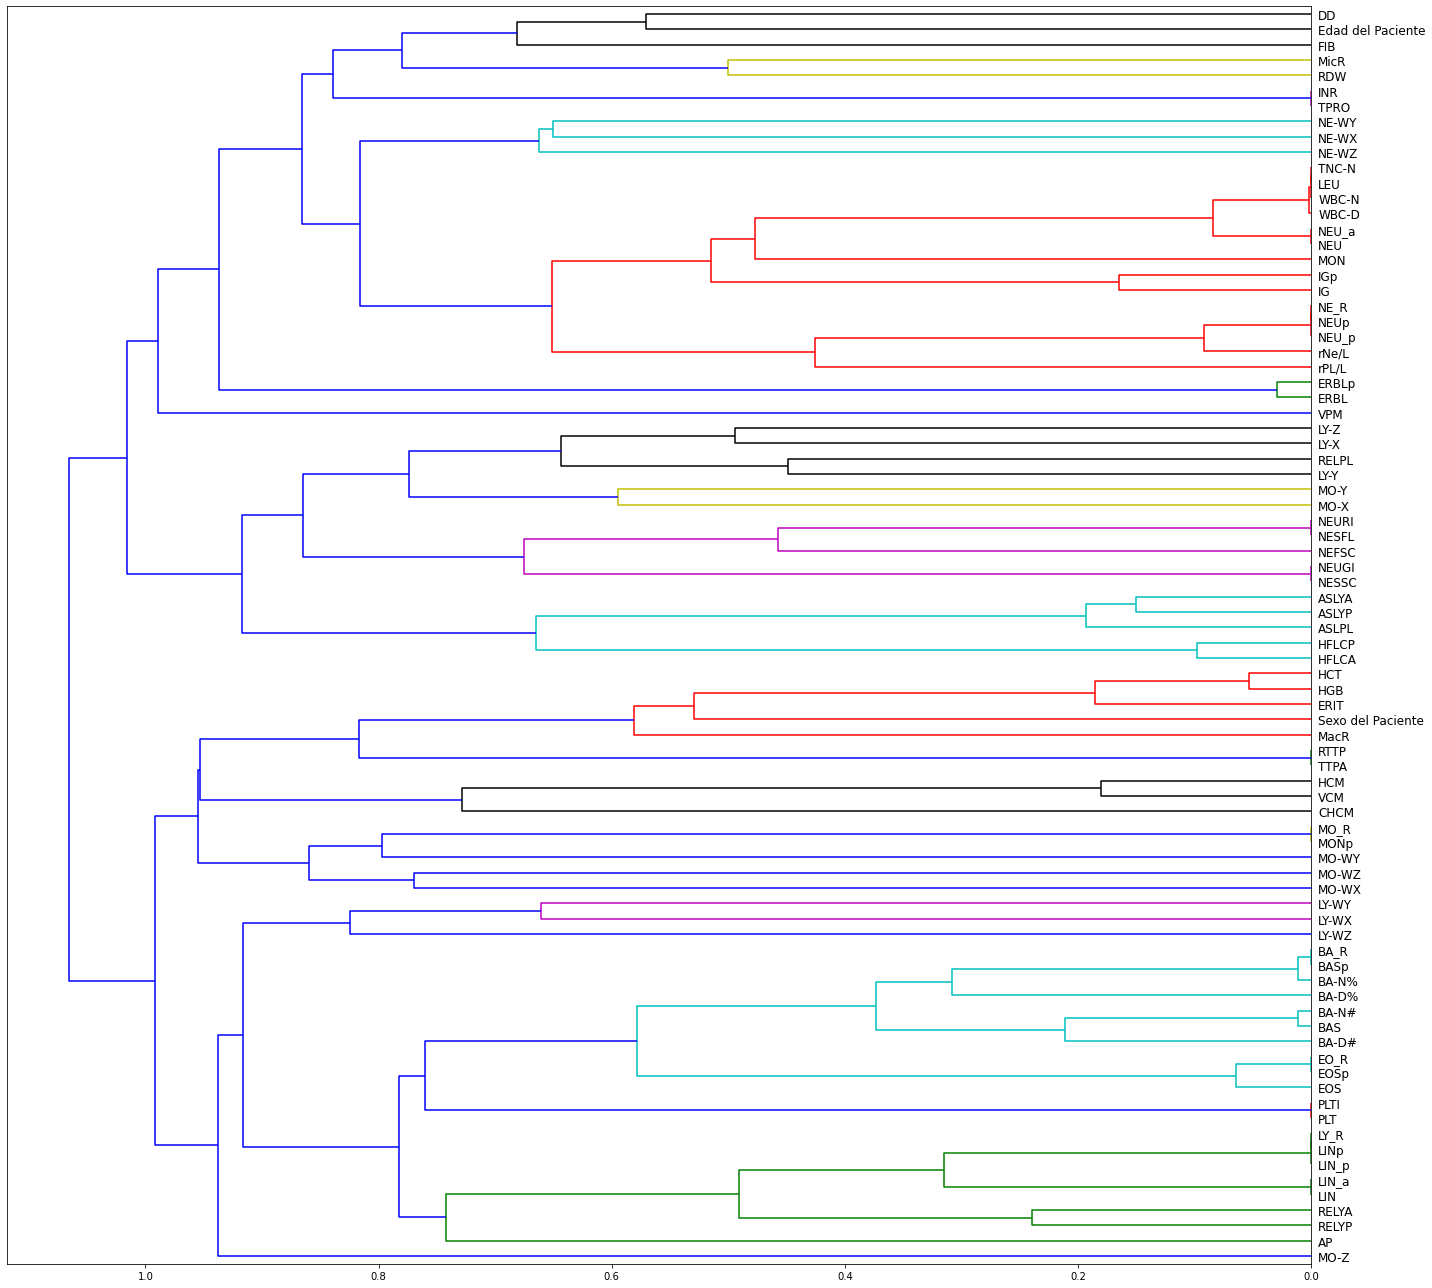

In [ ]:
import scipy 
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(20,18))
dendrogram = hc.dendrogram(z, labels=X_train.columns, 
      orientation='left', leaf_font_size=12)
plt.tight_layout()

A partir del dendrograma se observa como las variables que presentan alta similitud son las siguientes:

1. Lue, WBC-N, WBC-D y TNC
1. INR y TPRO 
1. Neu_a, Neu
1. NE_R, NEUp, NEU_p
1. NEURI, NESFL
1. NEUGI, NESSC
1. RTTP, TTPA
1. MO_R; MONp
1. BAR, BASP
1. EOR, EOSp
1. PLTI, PLT
1. LYR, LINp, LIN_p
1. LINa, LIN

Por tanto, se decide una de cada conjunto de variables redundantes.

In [ ]:
#drop variables
"""
1. Lue, WBC-N, WBC-D y TNC
1. INR y TPRO 
1. Neu_a, Neu
1. NE_R, NEUp, NEU_p
1. NEURI, NESFL
1. NEUGI, NESSC
1. RTTP, TTPA
1. MO_R; MONp
1. BAR, BASp, BA-N%, BA-N#, BAS, BA-D#
1. EOR, EOSp
1. PLTI, PLT
1. LYR, LINp, LIN_p
1. LINa, LIN 
"""

print(X_train.columns)
to_delete = ['WBC-N', "WBC-D", "TNC-N", "TPRO","NEU",'NEUp','NEU_p','NESFL','NESSC','TTPA','MONp','BASp','BA-N%','BA-N#','BAS','BA-D#','EOSp','PLT','LINp','LIN_p','LIN']
X_train = X_train.drop(to_delete,axis = 1)
X_test = X_test.drop(to_delete,axis = 1)



Index(['Sexo del Paciente', 'Edad del Paciente', 'LEU', 'NEU', 'NEUp', 'LIN',
       'LINp', 'MON', 'MONp', 'EOS', 'EOSp', 'BAS', 'BASp', 'IG', 'IGp',
       'ERIT', 'HGB', 'HCT', 'VCM', 'HCM', 'CHCM', 'RDW', 'ERBL', 'ERBLp',
       'PLT', 'PLTI', 'VPM', 'rNe/L', 'rPL/L', 'MacR', 'MicR', 'NE_R', 'LY_R',
       'MO_R', 'EO_R', 'BA_R', 'BA-D#', 'NEFSC', 'BA-D%', 'BA-N#', 'BA-N%',
       'HFLCA', 'HFLCP', 'LIN_a', 'LIN_p', 'LY-WX', 'LY-WY', 'LY-WZ', 'LY-X',
       'LY-Y', 'LY-Z', 'MO-WX', 'MO-WY', 'MO-WZ', 'MO-X', 'MO-Y', 'MO-Z',
       'NESFL', 'NESSC', 'NEU_a', 'NEU_p', 'NE-WX', 'NE-WY', 'NE-WZ', 'TNC-N',
       'WBC-D', 'WBC-N', 'ASLYP', 'ASLYA', 'RELPL', 'RELYP', 'RELYA', 'NEUGI',
       'NEURI', 'ASLPL', 'TPRO', 'AP', 'INR', 'TTPA', 'RTTP', 'FIB', 'DD'],
      dtype='object')


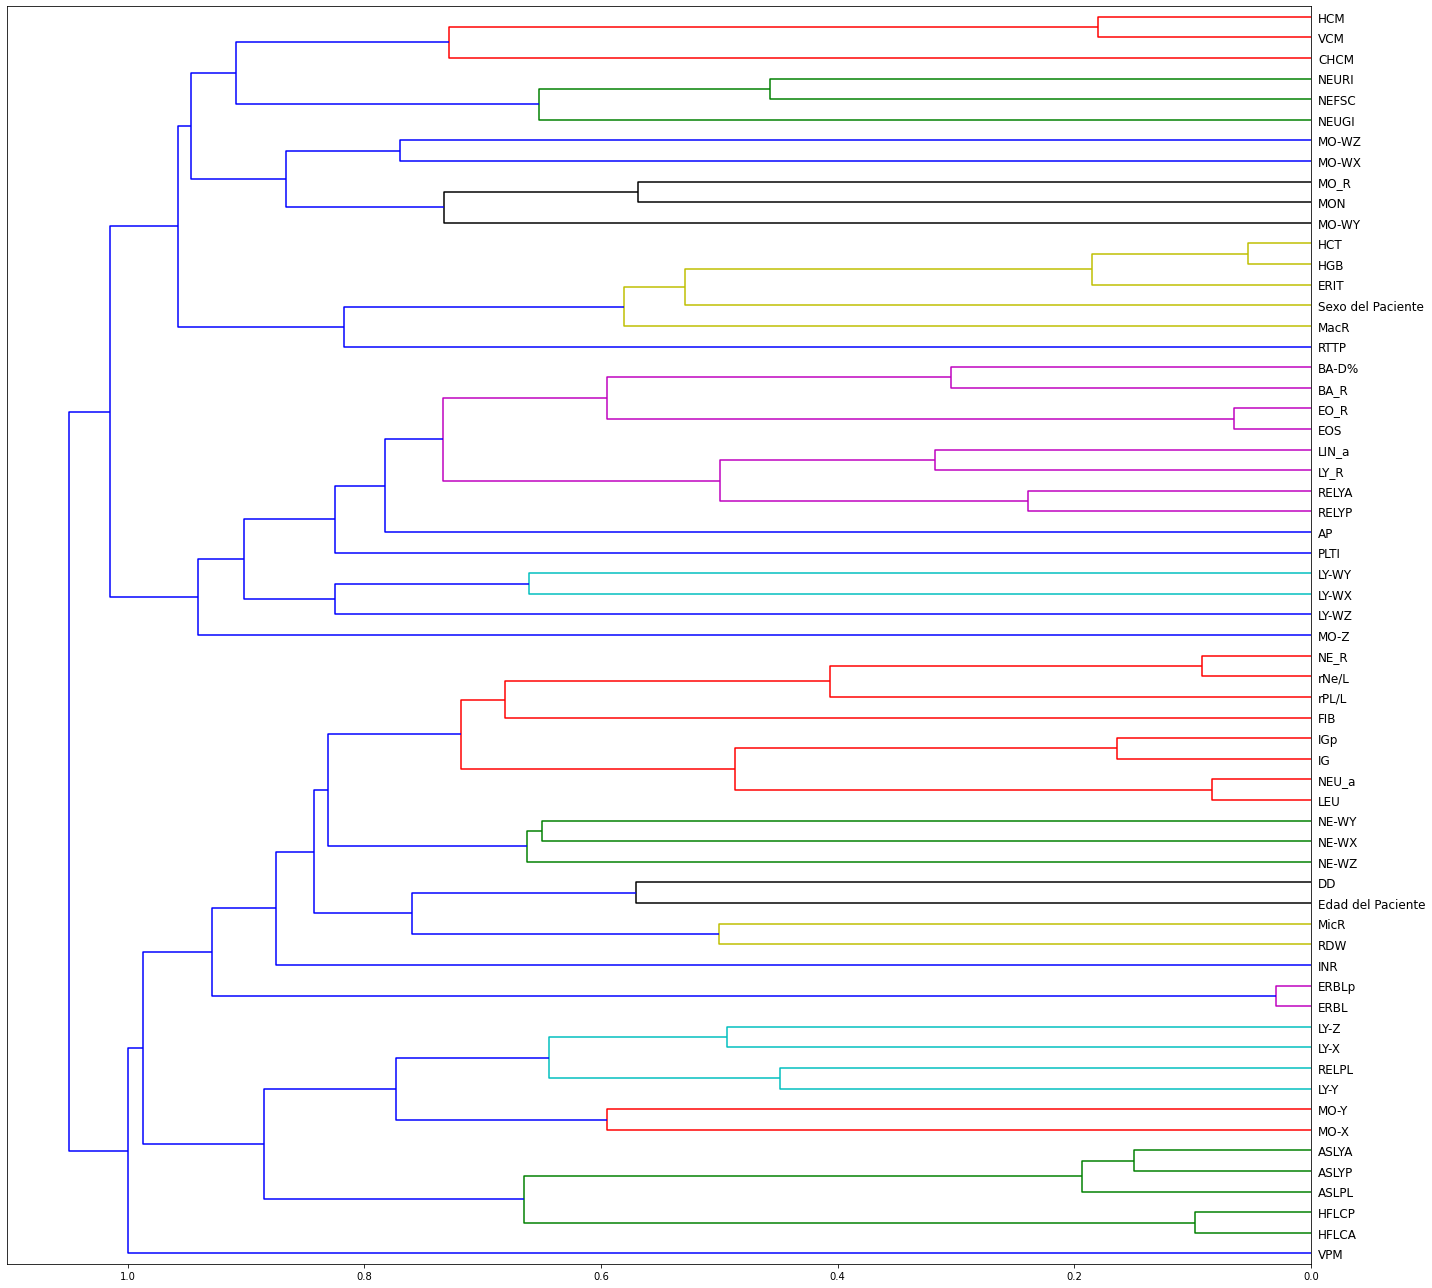

In [ ]:
#Reahcemos el dendrograma para verificar si las que son P y A (percentage y absolute) se agregan
corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(20,18))
dendrogram = hc.dendrogram(z, labels=X_train.columns, 
      orientation='left', leaf_font_size=12)
plt.tight_layout()


No parece que se agreguen de forma temprana.

# 9. Un árbol con todas las características

Se crea un árbol de clasificación con todas las características 

In [ ]:
from sklearn import tree

print(X_train.columns)

my_model_1 = tree.DecisionTreeClassifier(random_state=1)
my_model_2 = tree.DecisionTreeClassifier(random_state=1,max_depth = 4) #para comparar con el árbol que ellos tenían en la documentación

my_tree=my_model_1.fit(X_train, y_train)
my_tree_2 = my_model_2.fit(X_train,y_train)


#some statistics



Index(['Sexo del Paciente', 'Edad del Paciente', 'LEU', 'MON', 'EOS', 'IG',
       'IGp', 'ERIT', 'HGB', 'HCT', 'VCM', 'HCM', 'CHCM', 'RDW', 'ERBL',
       'ERBLp', 'PLTI', 'VPM', 'rNe/L', 'rPL/L', 'MacR', 'MicR', 'NE_R',
       'LY_R', 'MO_R', 'EO_R', 'BA_R', 'NEFSC', 'BA-D%', 'HFLCA', 'HFLCP',
       'LIN_a', 'LY-WX', 'LY-WY', 'LY-WZ', 'LY-X', 'LY-Y', 'LY-Z', 'MO-WX',
       'MO-WY', 'MO-WZ', 'MO-X', 'MO-Y', 'MO-Z', 'NEU_a', 'NE-WX', 'NE-WY',
       'NE-WZ', 'ASLYP', 'ASLYA', 'RELPL', 'RELYP', 'RELYA', 'NEUGI', 'NEURI',
       'ASLPL', 'AP', 'INR', 'RTTP', 'FIB', 'DD'],
      dtype='object')


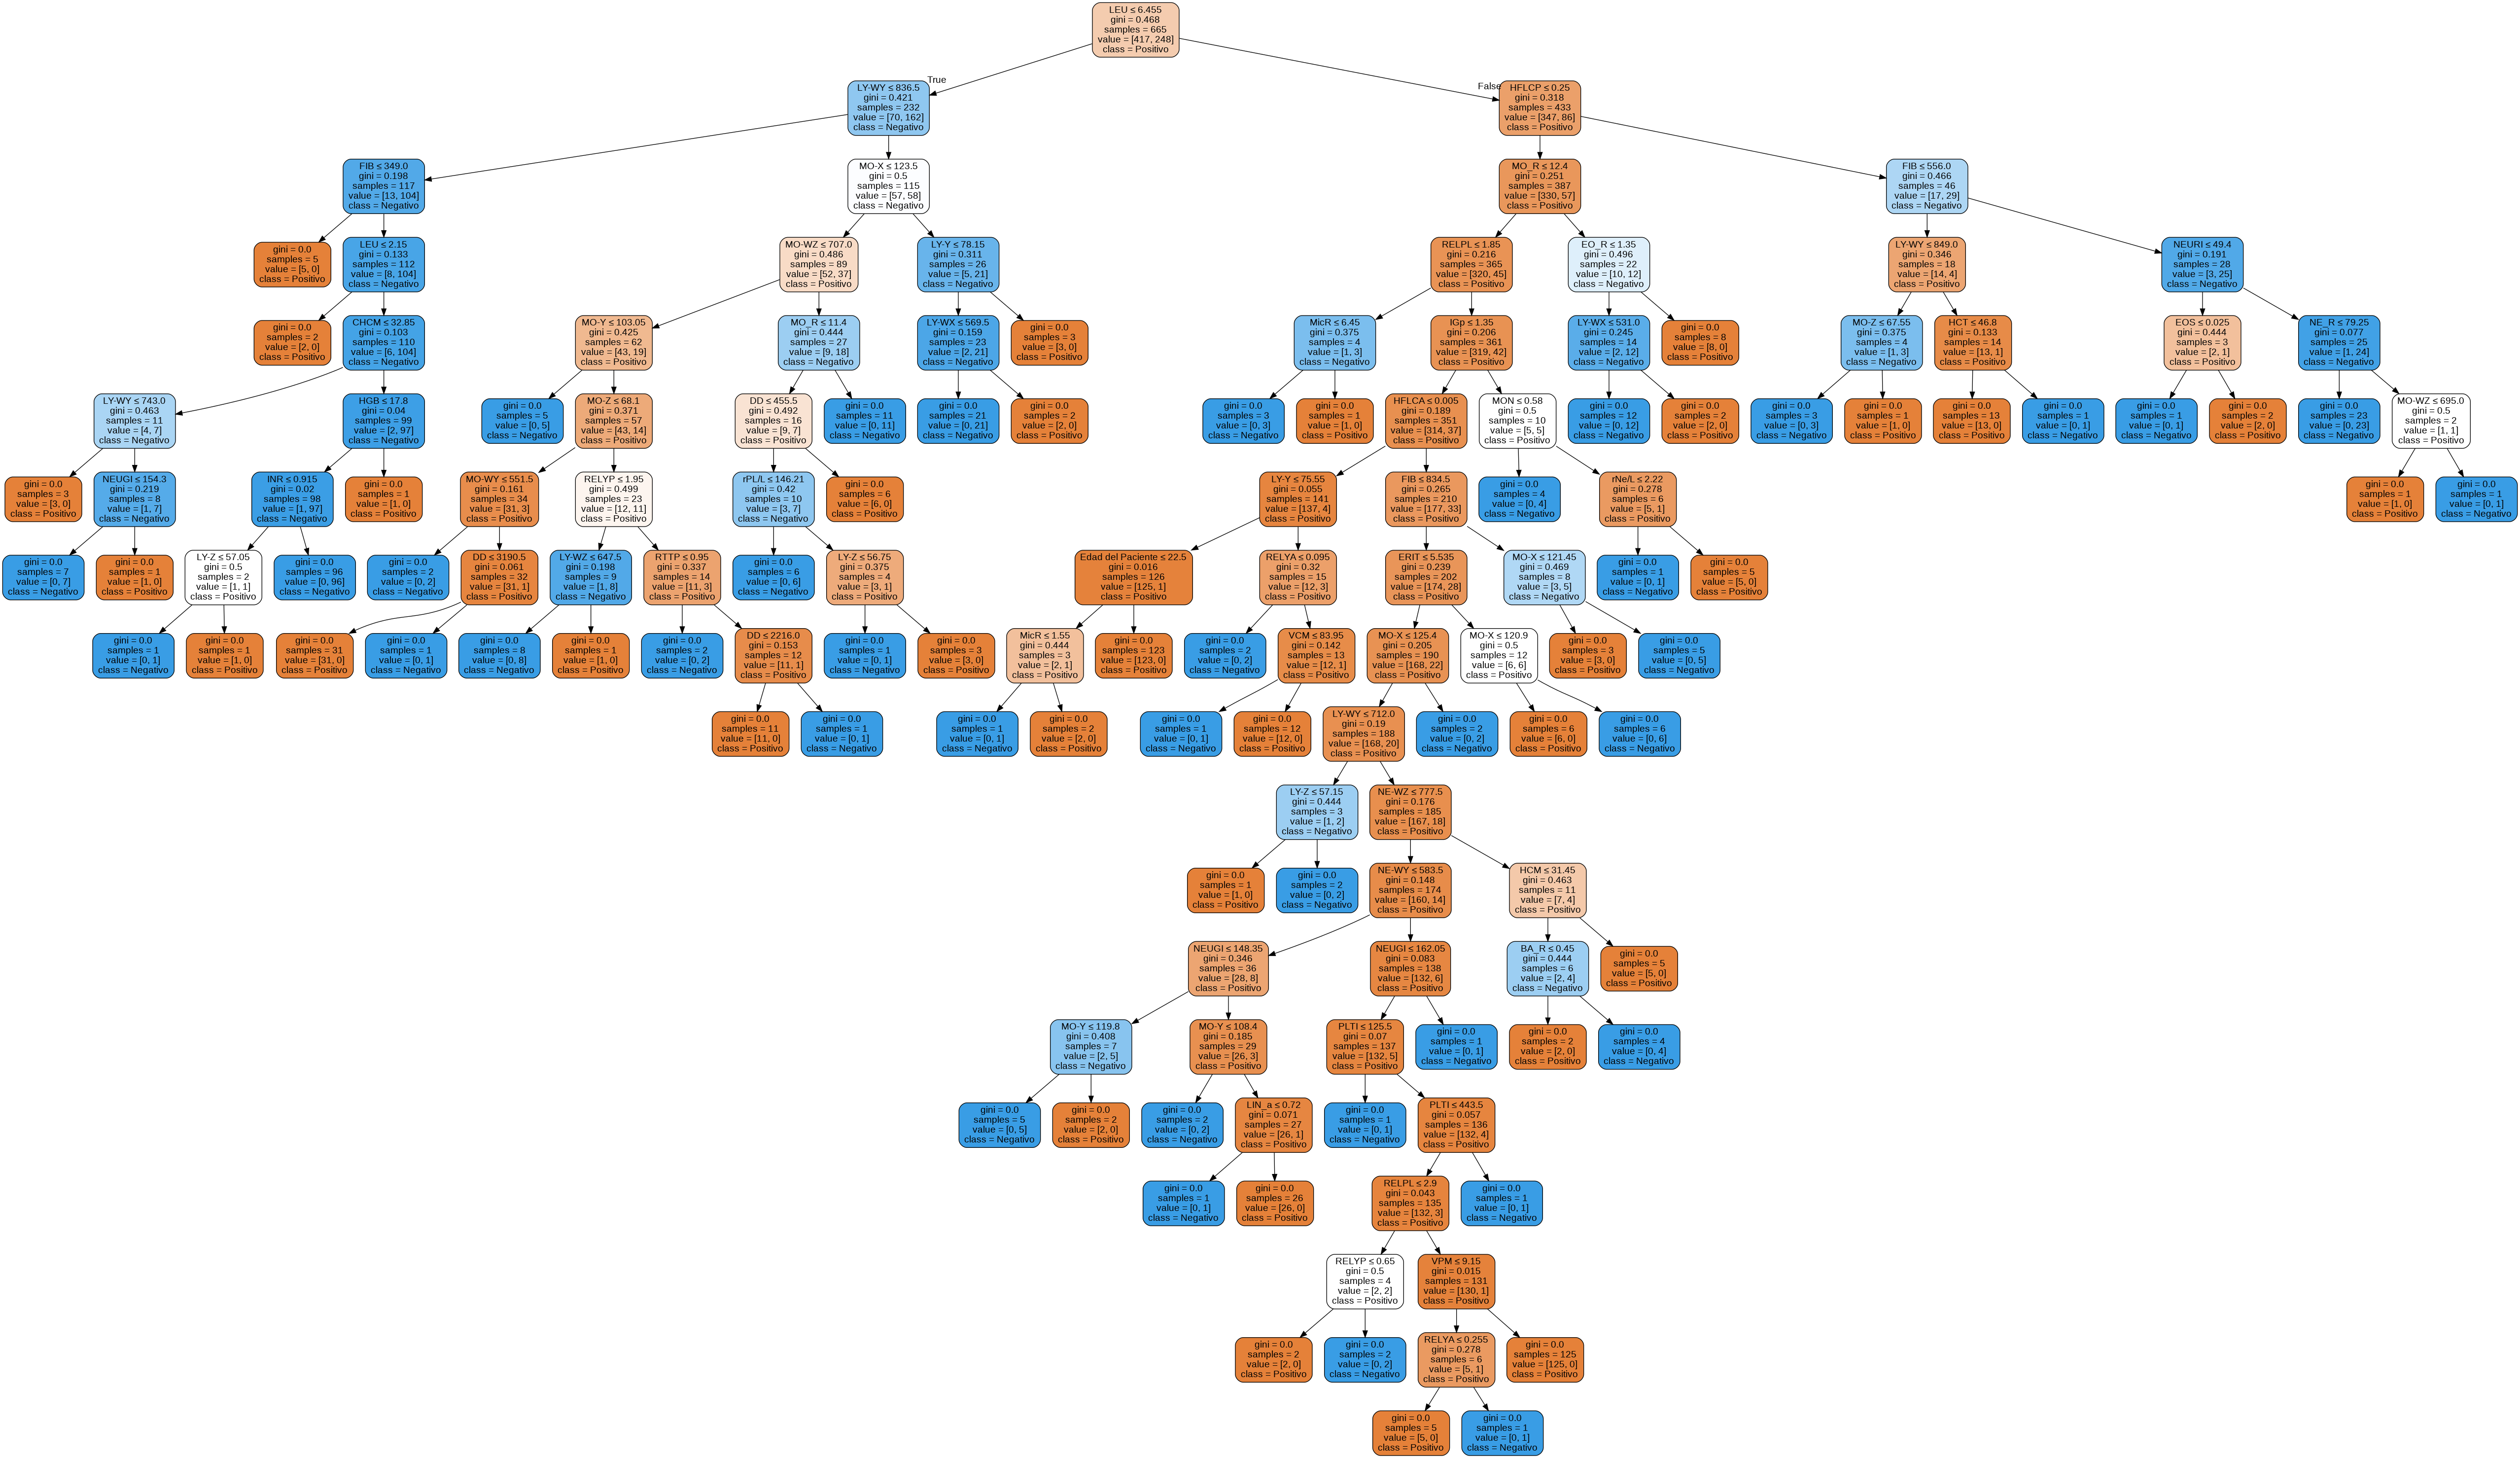

In [ ]:
dot_data = StringIO()
export_graphviz(my_tree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns,class_names=['Positivo','Negativo'])


graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

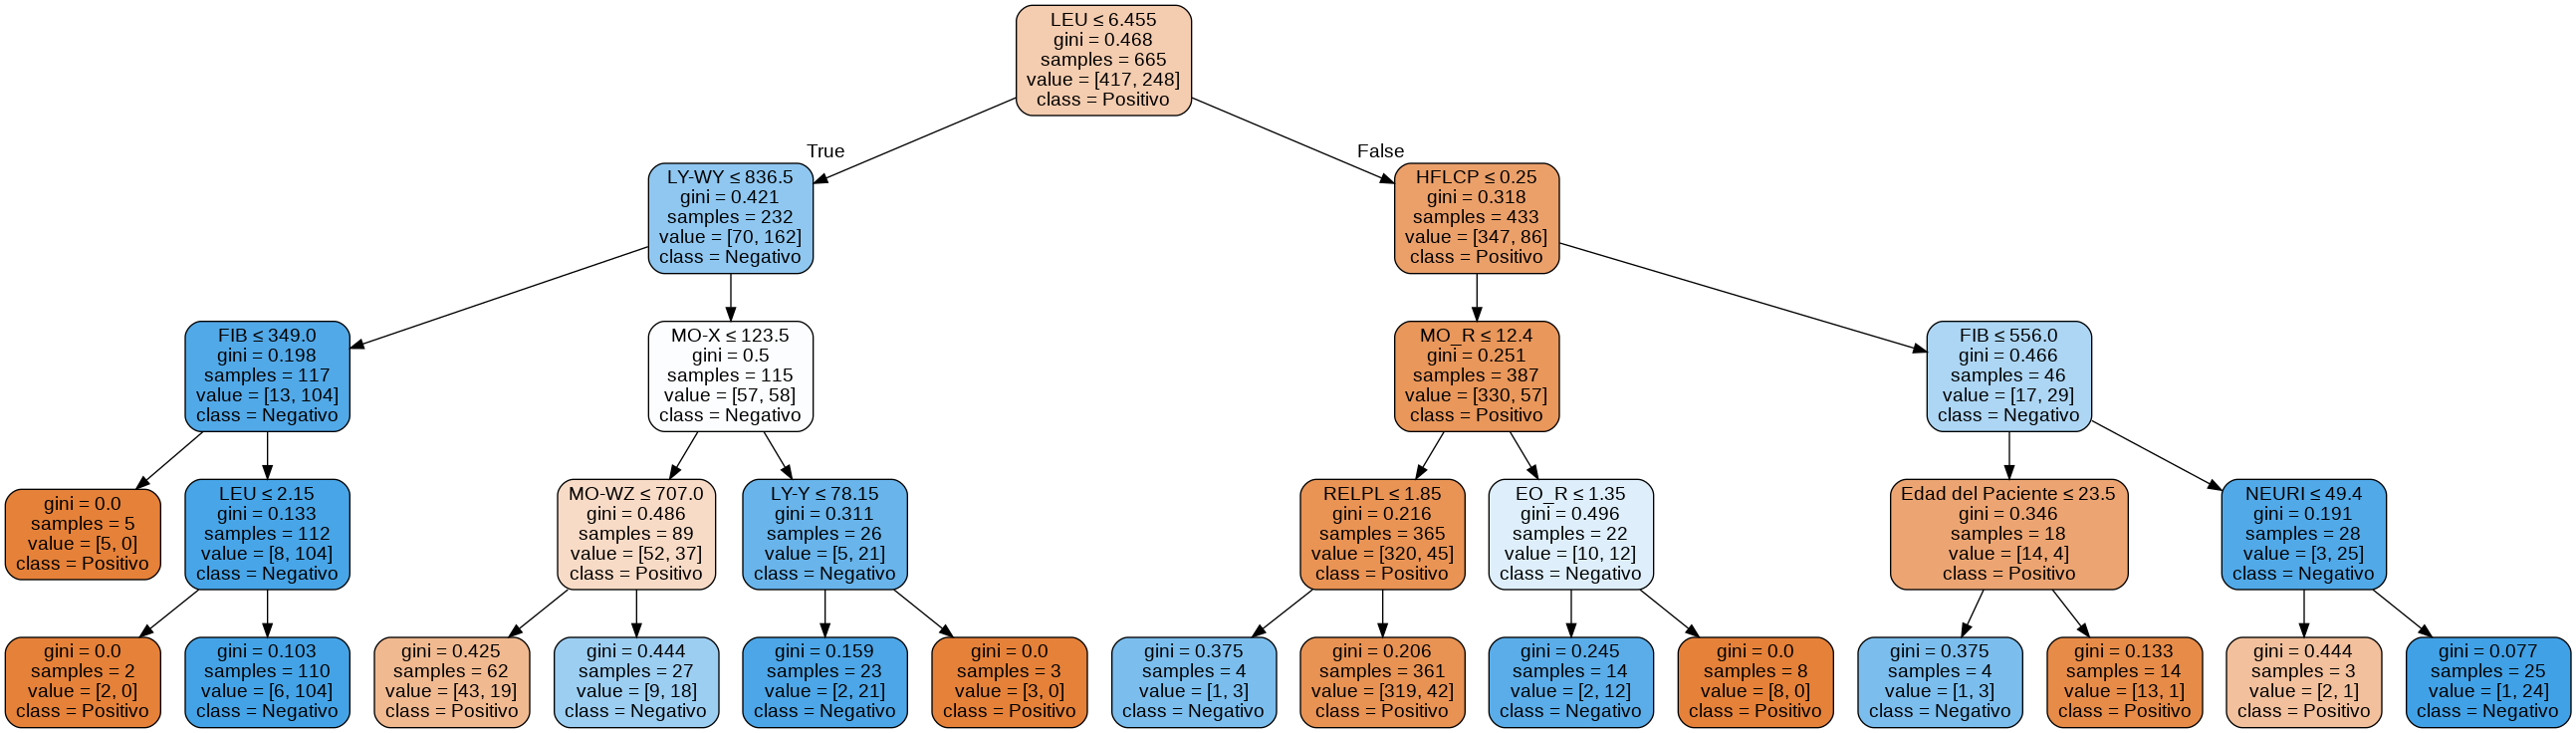

In [ ]:
dot_data = StringIO()
export_graphviz(my_tree_2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns,class_names=['Positivo','Negativo'])


graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# 10. Búsqueda de hiperparámetros en 50 árboles (Random Forest)

In [ ]:
# GridSearchCV
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3,15), 'min_samples_leaf':np.arange(5,30,5)}

# Creamos un árbol de clasificación
forest=RandomForestClassifier(n_estimators=50,
                              random_state=0,max_features="sqrt",n_jobs=-1,oob_score=True,bootstrap=True)

# Usamos gridsearch para evaluar los parámetros
forest = GridSearchCV(forest, param_grid, cv=3)


forest=forest.fit(X_train, y_train)
print(forest.best_params_)

# Entrenamos el modelo
my_model = forest.best_estimator_
my_forest=my_model.fit(X_train, y_train)



{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 5}


A partir de 50 árboles por medio de Random Forest con validación cruzada se obtiene gini como criterio, un máximo de profundidad a 5 y un mínimo de muestras por hoja de 5. 

In [ ]:
crit = my_model.criterion
max_depth = my_model.max_depth
min_samples_leaf = my_model.min_samples_leaf

# 11. Random Forest (1000 árboles) con todas las características 

In [ ]:
#ojo, lo mejor es coger los parámetros que se obtienen de my_model, porque a veces, sobre todo si no se establece la semilla pueden salir resultados diferentes.



forest_1=RandomForestClassifier(n_estimators=1000,
                              random_state=0,max_features="sqrt",n_jobs=-1,oob_score=True,bootstrap=True, criterion= crit,max_depth=max_depth,min_samples_leaf=min_samples_leaf)

forest_1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
print(forest_1.oob_score_) #valor mediante validación cruzada

0.837593984962406


# 12. Selección de características (FS)

La selección de características se entiende como una disminución del número de éstas, en función de un criterio elegido por el usuario, escogiendo aquellas que se consideran más informativas y eliminando aquellas que son irrelevantes. 

**Importancia de cada característica**

La importancia de características desempeña un papel importante, ya que proporciona una visión de los datos, del modelo y la base para la reducción de la dimensionalidad y la selección de características que pueden mejorar la eficiencia y la eficacia de un modelo predictivo en el problema.

1.0


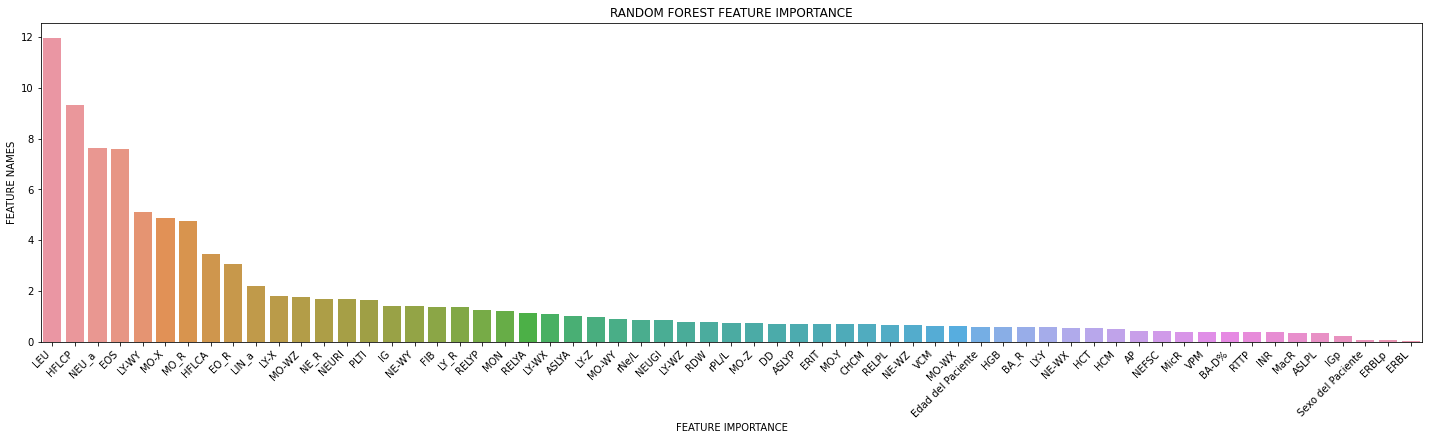

In [ ]:
import seaborn as sns
#Plot feature importance
def plot_feature_importance(importance,names,model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  fig = plt.figure(figsize=(20,6))
  #Plot Searborn bar chart
  sns.barplot(y=fi_df['feature_importance'], x=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')
  plt.tight_layout()
  fig.autofmt_xdate(rotation=45)


plot_feature_importance(forest_1.feature_importances_*100,X_train.columns,'RANDOM FOREST ')

print(np.sum(forest_1.feature_importances_))

A partir de este gráfico se puede observar la importancia de cada característica haciendo uso de Random Forest. Así pues, LEU es la variable que aporta mayor información al realizar la tarea de clasificación, con lo que permitirá, en mayor medida, diferenciar un positivo y un negativo. No obstante, las tres siguientes variables HFLCP, NEU_a, EOS y LY-WY también presentan información relevante para la predicción de la variable 19nCv. Por esta razón, las 5 características serán estudiadas posteriormente mediante *partials plot*. 



**Selección de las características en base a la importancia de éstas**

In [ ]:
#SelectFromModel

scores_cv = []
thresholds = np.sort(forest_1.feature_importances_) # obtiene la importancia de cada característica
i = 0
for thresh in thresholds:
    print("{} de {}".format(i,len(thresholds)))
    selection = SelectFromModel(forest_1, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = RandomForestClassifier(n_estimators=500, n_jobs=-1,criterion="gini",max_depth=5,min_samples_leaf=5,random_state=0,max_features="sqrt",oob_score=True,bootstrap=True)
    #cv estimation
    sc =cross_val_score(selection_model, select_X_train, y_train, cv=10, scoring='accuracy',n_jobs=-1)
    scores_cv.append(sc)
    i+=1

0 de 61
1 de 61
2 de 61
3 de 61
4 de 61
5 de 61
6 de 61
7 de 61
8 de 61
9 de 61
10 de 61
11 de 61
12 de 61
13 de 61
14 de 61
15 de 61
16 de 61
17 de 61
18 de 61
19 de 61
20 de 61
21 de 61
22 de 61
23 de 61
24 de 61
25 de 61
26 de 61
27 de 61
28 de 61
29 de 61
30 de 61
31 de 61
32 de 61
33 de 61
34 de 61
35 de 61
36 de 61
37 de 61
38 de 61
39 de 61
40 de 61
41 de 61
42 de 61
43 de 61
44 de 61
45 de 61
46 de 61
47 de 61
48 de 61
49 de 61
50 de 61
51 de 61
52 de 61
53 de 61
54 de 61
55 de 61
56 de 61
57 de 61
58 de 61
59 de 61
60 de 61


Text(0, 0.5, 'Accuracy')

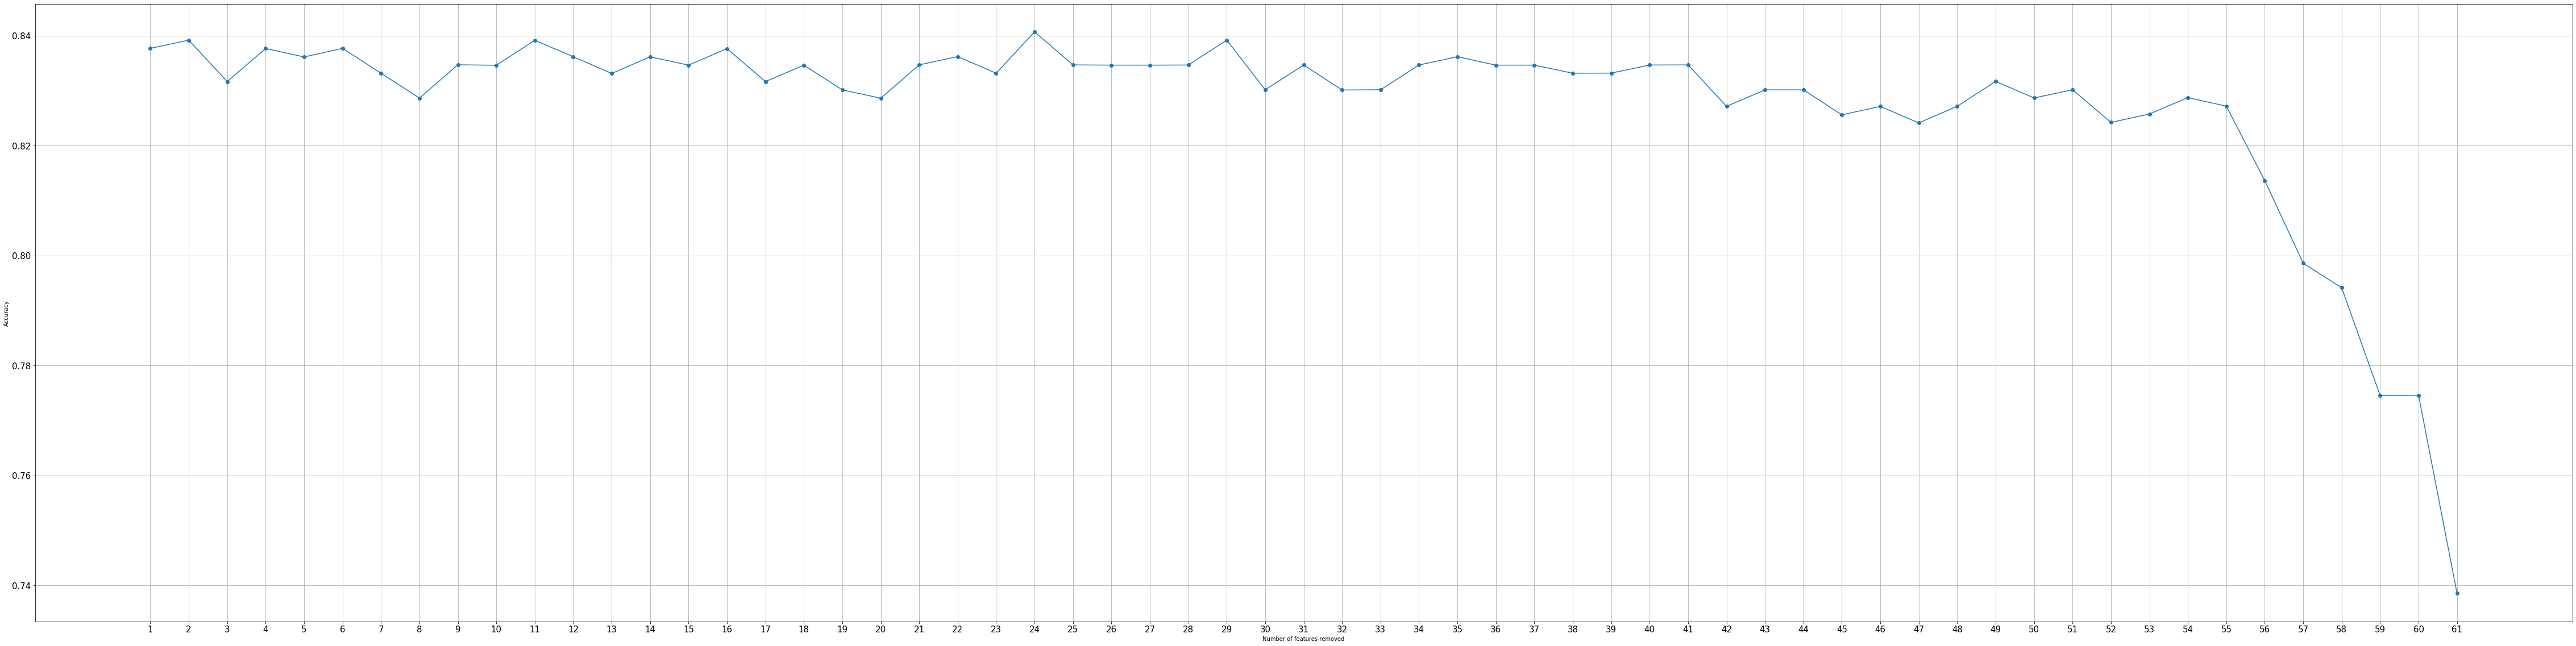

In [ ]:
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.figure(figsize = (80,20))
sc_cv = np.asarray(scores_cv)
scores_m = np.mean(sc_cv,axis = 1)
scores_std = np.std(sc_cv,axis = 1)
xx = np.arange(len(scores_m))
plt.plot(xx,scores_m,'o-')
plt.grid()
_ = plt.xticks(xx,labels= np.arange(1,len(scores_m)+1))
plt.xlabel('Number of features removed')
plt.ylabel('Accuracy')




Esta gráfica muestra el ***accuracy*** que se alcanza cuando se escogen X características. Desde la izquierda hacia la derecha se van quitando variables consecutivamente, y se puede observar que la predicción del modelo no se degrada hasta llegar a 54 variables. Es decir, solo quedándonos con 7 variables, el modelo es capaz de tener el mismo desempeño en predicción que utilizando todas las variables. Estas característica son las 7 primeras representadas anteriormente en la gráfica "Random Forest Feature Importance".

Además siempre es preferible tener un modelo menos complejo para que de esta forma pueda haber una mejor generalizacion con la incorporación de datos nuevos.

# 13. Random Forest (1000 árboles) con FS 

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

#convert into a dataframe with sorted feature importances
fi = rf_feat_importance(forest_1,X_train)

#select the features
selected_features_RF = fi[:len(fi)-54]['cols'].to_list()
print("Numero de variables seleccionadas Pars:",len(selected_features_RF))
print("Selected features:",selected_features_RF)


X_train_FT = X_train[selected_features_RF]
X_test_FT = X_test[selected_features_RF]


Numero de variables seleccionadas Pars: 7
Selected features: ['LEU', 'HFLCP', 'NEU_a', 'EOS', 'LY-WY', 'MO-X', 'MO_R']


In [ ]:
forest_final=RandomForestClassifier(n_estimators=1000,
                              random_state=0,max_features="sqrt",n_jobs=-1,oob_score=True,bootstrap=True, criterion="gini",max_depth=5,min_samples_leaf=5,class_weight = "balanced")
forest_final.fit(X_train_FT, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)

0.8195488721804511


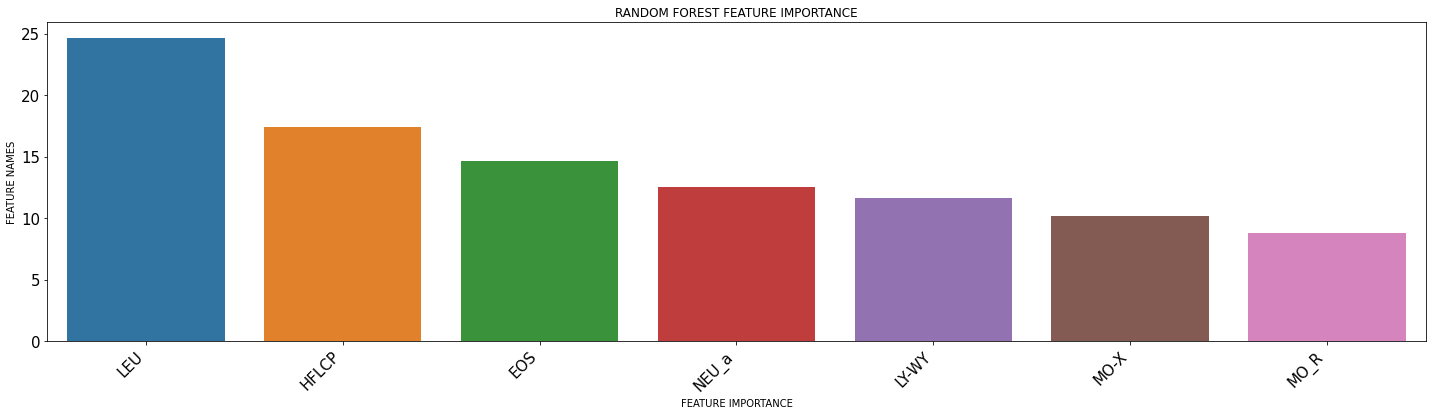

In [ ]:
print(forest_final.oob_score_) #valor mediante validación cruzada

plot_feature_importance(forest_final.feature_importances_*100,X_train_FT.columns,'RANDOM FOREST ')



Tras entrenar un modelo con las 7 variables que aportan más información para la predicción, en este gráfico se puede observar como se mantienen las 5 características más relevantes que se obtenían anteriormente, aunque en diferente orden. 

# 14. Evaluación en el conjunto de Test

In [ ]:
from sklearn.metrics import roc_auc_score

#árbol profundidad completo
y_pred_tree_1= my_model_1.predict(X_test)
acc_tree_1 = accuracy_score(y_test, y_pred_tree_1)
sensibilidad_tree_1 =recall_score(y_test, y_pred_tree_1)
#precision_tot=precision_score(y_test, y_pred_tot)
specificity_tree_1= confusion_matrix(y_test, y_pred_tree_1)[0][0]/(confusion_matrix(y_test, y_pred_tree_1)[0][0]+confusion_matrix(y_test, y_pred_tree_1)[0][1])
auc_tree_1 = roc_auc_score(y_test, y_pred_tree_1)

#árbol profundidad 4
y_pred_tree= my_model_2.predict(X_test)
acc_tree = accuracy_score(y_test, y_pred_tree)
sensibilidad_tree =recall_score(y_test, y_pred_tree)
#precision_tot=precision_score(y_test, y_pred_tot)
specificity_tree = confusion_matrix(y_test, y_pred_tree)[0][0]/(confusion_matrix(y_test, y_pred_tree)[0][0]+confusion_matrix(y_test, y_pred_tree)[0][1])
auc_tree = roc_auc_score(y_test, y_pred_tree)

#Todas las características
y_pred_tot=forest_1.predict(X_test)
acc_tot=accuracy_score(y_test, y_pred_tot)
sensibilidad_tot=recall_score(y_test, y_pred_tot)
#precision_tot=precision_score(y_test, y_pred_tot)
specificity_tot = confusion_matrix(y_test, y_pred_tot)[0][0]/(confusion_matrix(y_test, y_pred_tot)[0][0]+confusion_matrix(y_test, y_pred_tot)[0][1])
auc_tot = roc_auc_score(y_test, y_pred_tot)


#7 características 
y_pred_7=forest_final.predict(X_test_FT)
acc_7=accuracy_score(y_test, y_pred_7)
sensibilidad_7=recall_score(y_test, y_pred_7)
#precision_7=precision_score(y_test, y_pred_7)
specificity_7 = confusion_matrix(y_test, y_pred_7)[0][0]/(confusion_matrix(y_test, y_pred_7)[0][0]+confusion_matrix(y_test, y_pred_7)[0][1])
auc_7 = roc_auc_score(y_test, y_pred_7)

Tabla = pd.DataFrame({ "Prestaciones en test":["Accuracy","Sensibility",'Specificity',"AUC ROC"],
                      "Decision Tree" : [acc_tree_1,sensibilidad_tree_1,specificity_tree_1, auc_tree_1], 
                      "Decision Tree depth 4" : [acc_tree,sensibilidad_tree,specificity_tree, auc_tree], 
                      "Random Forest total" : [acc_tot,sensibilidad_tot,specificity_tot, auc_tot], 
                      "Random Forest 7 features " : [acc_7,sensibilidad_7,specificity_7,auc_7]})
Tabla

,Prestaciones en test,Decision Tree,Decision Tree depth 4,Random Forest total,Random Forest 7 features
0,Accuracy,0.742515,0.772455,0.826347,0.802395
1,Sensibility,0.596774,0.629032,0.645161,0.677419
2,Specificity,0.828571,0.857143,0.933333,0.876190
3,AUC ROC,0.712673,0.743088,0.789247,0.776805


En una vista general de la tabla, los modelos propuestos obtienen buenas prestaciones en las distintas medidas de rendimiento.

Se observa mejoría al utilizar varios árboles como modelo (Random Forest) que uno solo, tanto para una profudidad de 4 como sin esta restricción. 

A su vez, se percibe como con un número reducido de variables de entrada, en concreto 7, aumenta el valor de la sensibilidad a costa de la reducción del resto de métricas.

Cabe destacar el valor de especificidad, cercano a 0.9, con lo que el modelo presenta una elevada capacidad de detección de los casos negativos como los que realmente no presentan la enfermedad. 

Como marcador general, se observa una tasa de acierto de 0.8, lo que indica que existe una elevada cantidad de predicciones realizadas correctamente. 

Mediante la medida AUC, se evalúa el modelo en base a cuánto de fiable es éste. En este caso, se podría decir que el método predictivo presenta una alta fiabilidad. 

Por último, la que presenta un menor valor, aunque sigue siendo alto es la sensibilidad. Por tanto, el modelo presenta una capacidad de detección de los casos positivos como los realmente enfermos menor con respecto al resto de medidas analizadas. 

Text(0.5, 1.0, 'Árbol profundidad completo')

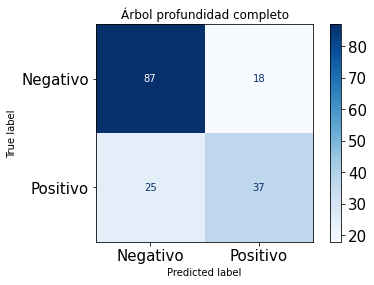

In [ ]:
from sklearn.metrics import plot_confusion_matrix

#árbol profundidad completo
plot_confusion_matrix(my_model_1, X_test, y_test,display_labels=["Negativo","Positivo"],
                                 cmap=plt.cm.Blues)
plt.title("Árbol profundidad completo")


Text(0.5, 1.0, 'Árbol profundidad 4')

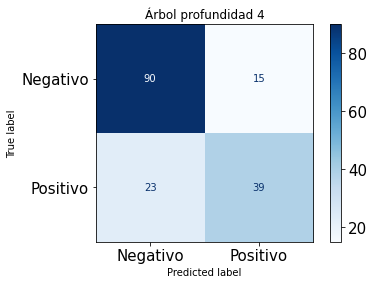

In [ ]:
#árbol profundidad 4

plot_confusion_matrix(my_model_2, X_test, y_test,display_labels=["Negativo","Positivo"],
                                 cmap=plt.cm.Blues)  
plt.title("Árbol profundidad 4")


Text(0.5, 1.0, 'Random Forest total')

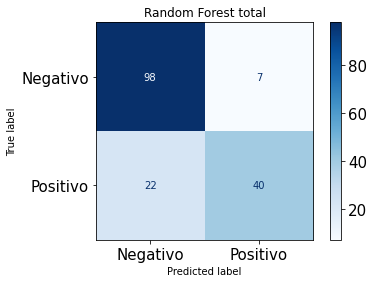

In [ ]:
#Todas las características

plot_confusion_matrix(forest_1, X_test, y_test, display_labels=["Negativo","Positivo"],
                                 cmap=plt.cm.Blues)  

plt.title("Random Forest total")

Text(0.5, 1.0, 'Random Forest 7 features')

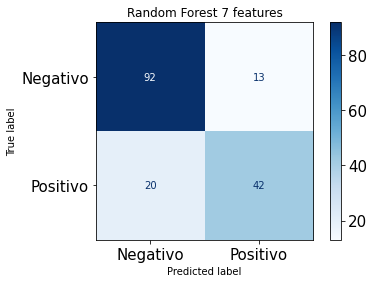

In [ ]:
#18 características 

plot_confusion_matrix(forest_final, X_test_FT, y_test, display_labels=["Negativo","Positivo"],
                                 cmap=plt.cm.Blues) 

plt.title("Random Forest 7 features")

# 15. Partials plots 

In [ ]:
!pip install pdpbox 

## Partials plots 1D

<Figure size 432x288 with 0 Axes>

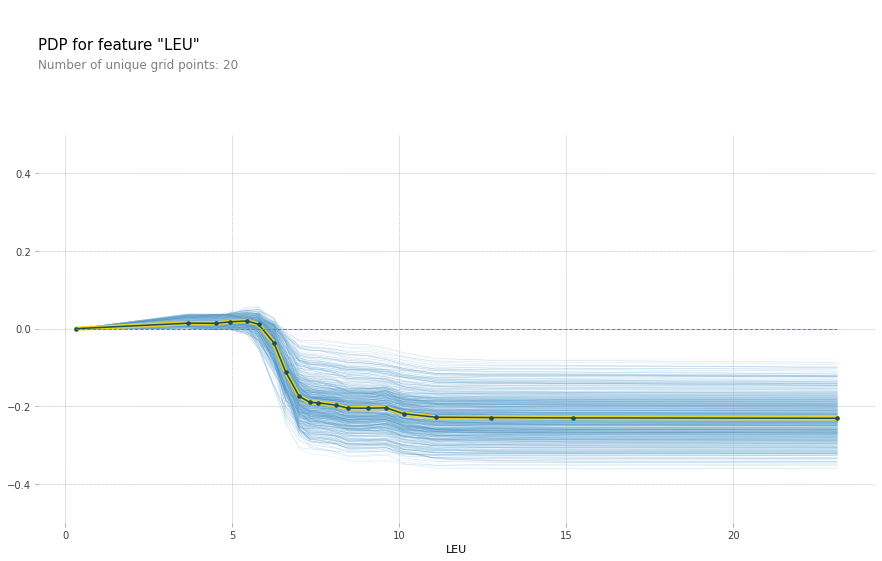

<Figure size 432x288 with 0 Axes>

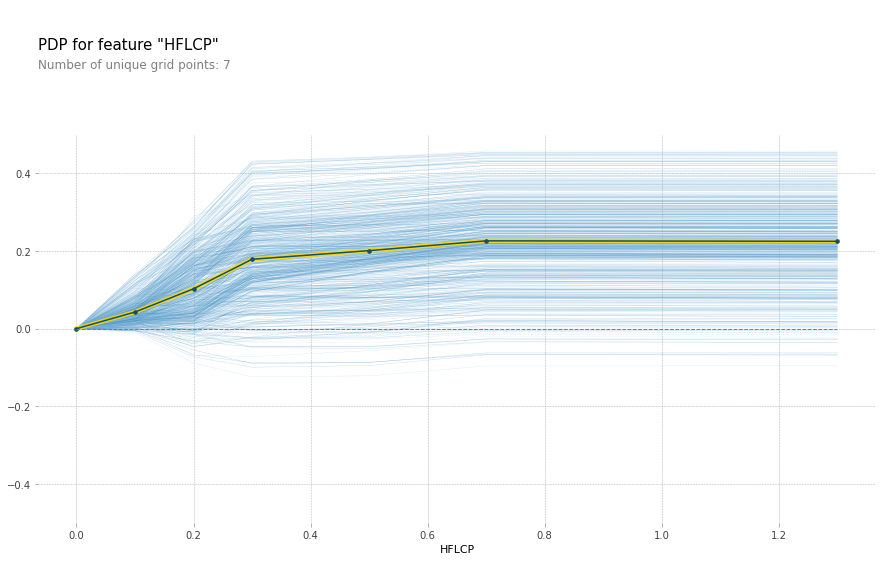

<Figure size 432x288 with 0 Axes>

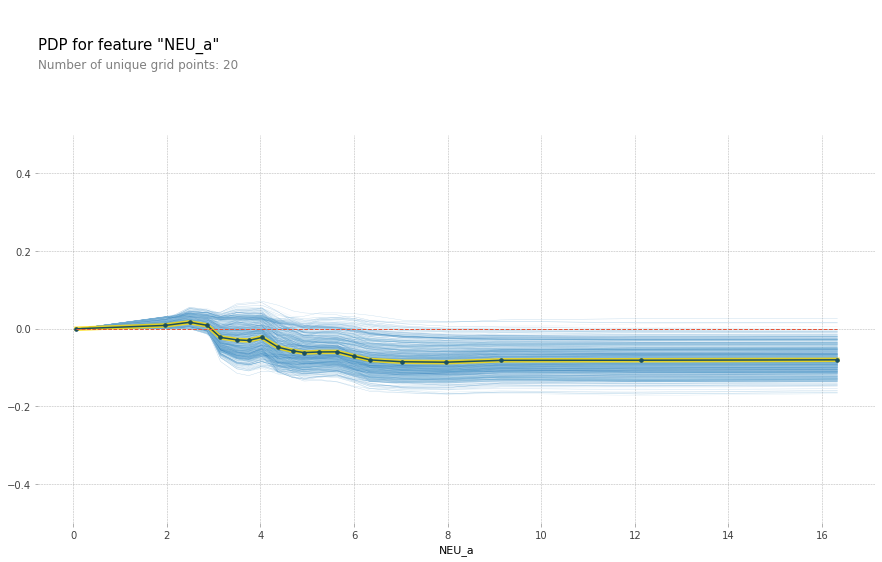

<Figure size 432x288 with 0 Axes>

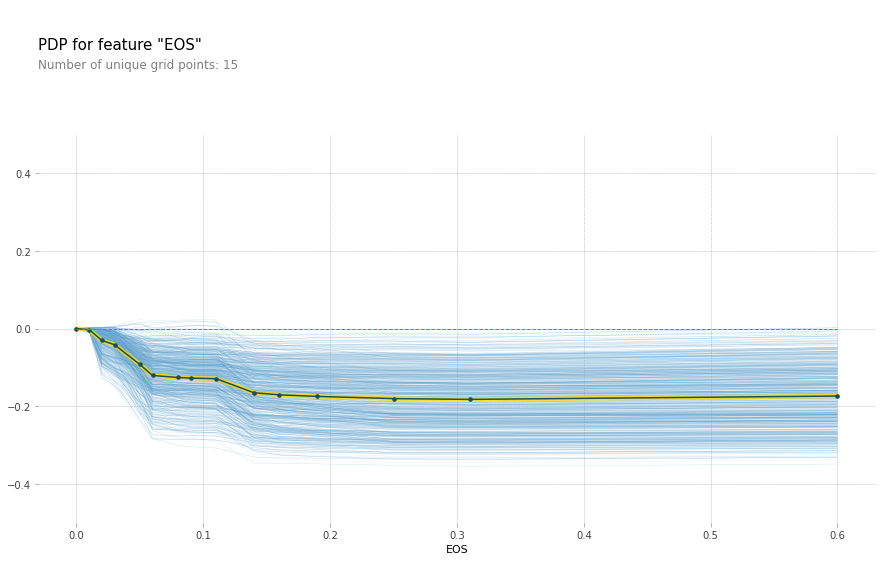

<Figure size 432x288 with 0 Axes>

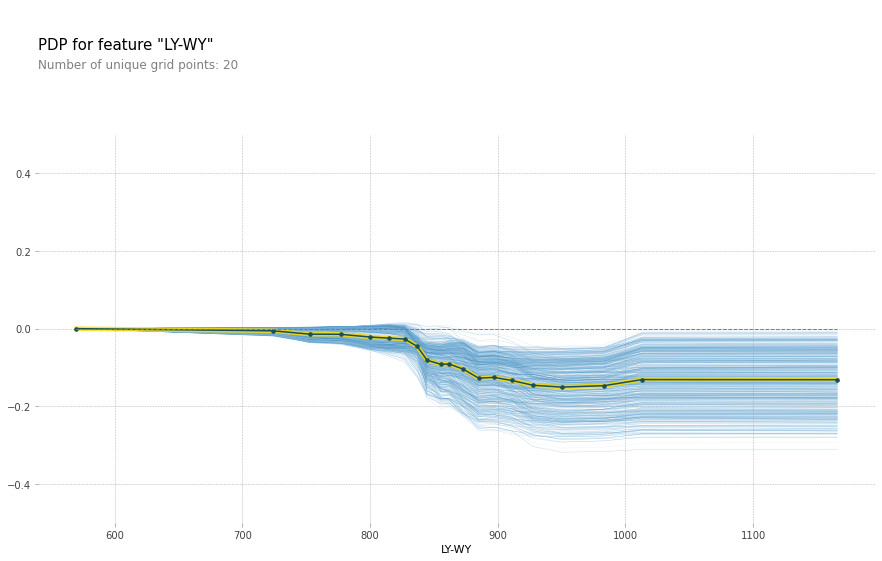

In [ ]:
from pdpbox import pdp, get_dataset, info_plots


for i in X_train_FT.columns[:5]:
  pdp_goals = pdp.pdp_isolate(model=forest_final, dataset=X_train_FT, model_features=X_train_FT.columns, feature=i, num_grid_points = 20)

  plt.figure()
  pdp.pdp_plot(pdp_goals, i, plot_lines=True, cluster = False, n_cluster_centers= None) 

  plt.ylim(-.5,.5)

La representación de los *partial dependence plots* de las 5 mejores características, da una idea de la correlación que guarda dichas características (LEU, HFLCP, NEU_a, EOS, LY-WY) con la probabilidad de detectar la presencia de COVID-19, manteniendo el resto de variables en promedio.

- En el *partial dependence plot* de **LEU** se puede observar que hasta un valor de LEU = 5 la probabilidad de ser positivo o negativo no es concluyente, se mantiene nula. Conforme aumenta la cantidad de LEU en sangre, la probabilidad de tener COVID-19 disminuye en un 20%, **correlación negativa**. Además, la gráfica presenta una saturación a partir de LEU = 10 aproximadamente,es decir, la probabilidad de ser negativo no se ve modifica.

- Por otro lado, el *partial dependence plot* de **HFLC** muestra una **correlación positiva** y una gráfica saturada. En este caso, la presencia de HFLC supone la presencia de COVID-19. Cuando HFCL = 0.3, se observa una probabilidad de un 20% de presentar COVID-19 en el organismo.

- Las gráficas de **NEU_a**, **EOS** y **LY-WY** se comportan del mismo modo que LEU presentando una **correlación negativa** y por tanto su presencia supone una disminución de la probabilidad de presentar COVID-19.

(-0.2, 0.2)

<Figure size 432x288 with 0 Axes>

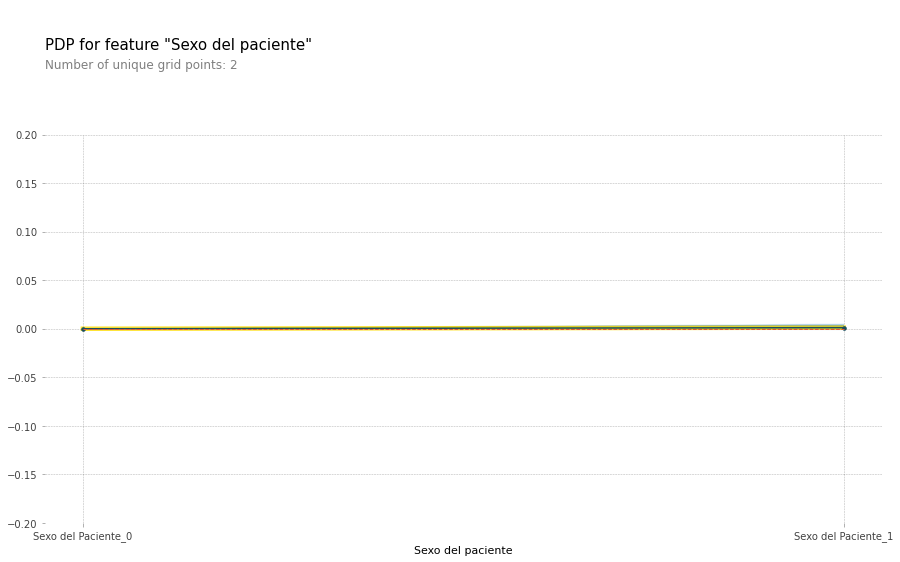

In [ ]:
pdp_goals = pdp.pdp_isolate(model=forest_1, dataset=X_train, model_features=X_train.columns, feature="Sexo del Paciente", num_grid_points = 20)

plt.figure()
pdp.pdp_plot(pdp_goals, "Sexo del paciente", plot_lines=True, cluster = False, n_cluster_centers= None) 

plt.ylim(-.2,.2)

(-0.2, 0.2)

<Figure size 432x288 with 0 Axes>

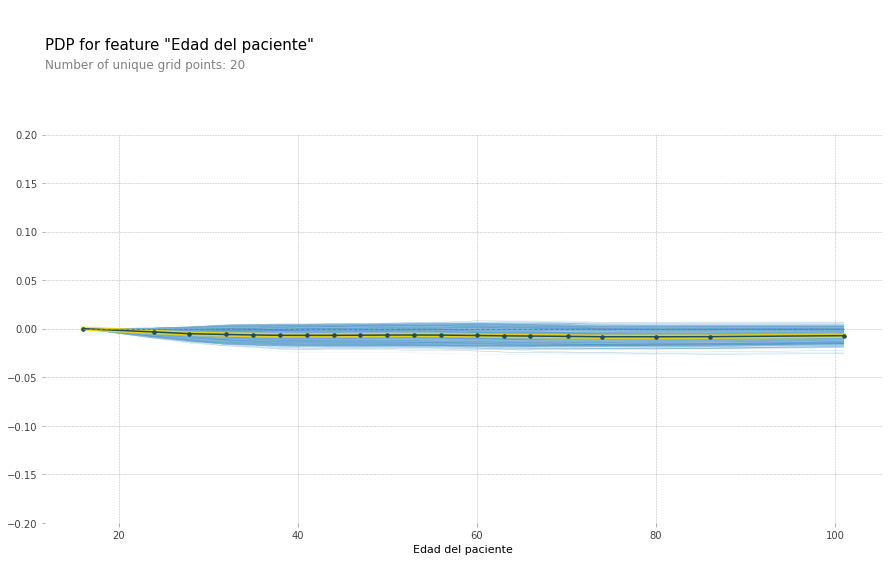

In [ ]:
pdp_goals = pdp.pdp_isolate(model=forest_1, dataset=X_train, model_features=X_train.columns, feature="Edad del Paciente", num_grid_points = 20)

plt.figure()
pdp.pdp_plot(pdp_goals, "Edad del paciente", plot_lines=True, cluster = False, n_cluster_centers= None) 

plt.ylim(-.2,.2)

## Partials plots 2D

TypeError: ignored

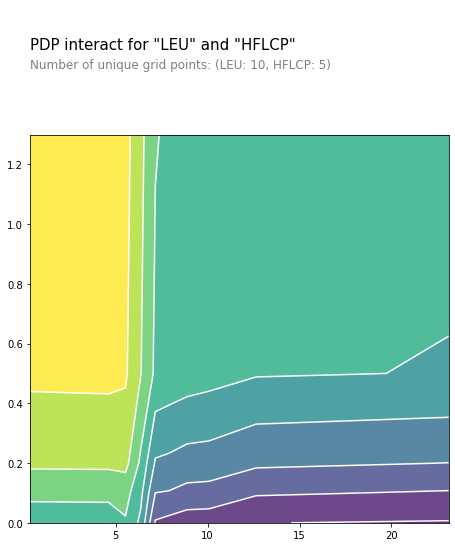

In [ ]:
features_to_plot = ['LEU', 'HFLCP']
inter1  =  pdp.pdp_interact(model=forest_final, dataset=X_train_FT, model_features=X_train_FT.columns, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot,  plot_type='contour')
plt.show()


In [ ]:
features_to_plot = ['LEU', 'NEU_a']
inter1  =  pdp.pdp_interact(model=forest_final, dataset=X_train_FT, model_features=X_train_FT.columns, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()